In [1]:
# importing desi premade stuff in nersc

%pylab inline
import desispec
import desitarget
import desimodel.io
print('desimodel ', desimodel.__version__)
print('desispec  ', desispec.__version__)
print('desitarget', desitarget.__version__)

#fiberpos = desimodel.io.load_fiberpos()
#figure(figsize=(8,8))
#plot(fiberpos['X'], fiberpos['Y'], 'k.', alpha=0.5, markeredgecolor='none')


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
desimodel  0.18.0
desispec   0.56.5
desitarget 2.6.0


In [2]:
# general imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from astropy.io import fits
from astropy.table import Table
from astropy.convolution import convolve, Gaussian1DKernel


import datetime
date = datetime.datetime.now()
day = date.strftime("%d")
month = date.strftime("%b")

# imports for the sky map
from astropy.io import ascii
import astropy.units as u
from astropy.coordinates import SkyCoord

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=69.3 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.287)

#import plotly.graph_objects as go
import seaborn as sns
from matplotlib.gridspec import GridSpec

import scipy


In [3]:
import astropy.coordinates as coord
from astropy.coordinates import ICRS, Galactic
from astropy.table import Table, hstack, vstack
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import astropy.units as u

In [4]:
# iron coadded fits table
path = '/global/cfs/cdirs/desi/science/mws/redux/iron/rv_output/230211/'
filename = path+'rvtab-hpxcoadd-all.fits'

In [5]:
# checking tables in fits file
hdul=fits.open(filename)
hdul.info()
hdul.close()

Filename: /global/cfs/cdirs/desi/science/mws/redux/iron/rv_output/230211/rvtab-hpxcoadd-all.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  RVTAB         1 BinTableHDU    128   6165491R x 37C   [D, D, D, D, D, D, D, D, D, D, D, D, D, K, D, D, D, D, D, D, D, D, K, K, 2A, D, D, K, E, E, E, L, D, 6A, 45A, 7A, 6A]   
  2  FIBERMAP      1 BinTableHDU    203   6165491R x 81C   [K, J, D, D, E, E, E, K, B, 3A, D, J, I, 8A, J, J, 4A, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, I, E, E, E, E, K, 2A, E, E, E, E, 1A, K, K, K, K, K, K, D, D, I, E, I, I, E, E, E, E, D, E, D, E, E, 45A, K, K, K, K, K, K, K, K, K, K, K, K, K]   
  3  SCORES        1 BinTableHDU     95   6165491R x 43C   [K, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, 45A]   
  4  GAIA          1 BinTableHDU    346   6165491R x 153C   [K, 28A, K, K, D, D, E, D, E, D, E, E, E, D

In [6]:
rvtab = Table.read(filename, hdu = "RVTAB")
fmap = Table.read(filename, hdu = "FIBERMAP")
gaiatab = Table.read(filename, hdu = "GAIA")

In [7]:
print(f"Tiles table columns: {rvtab.colnames}")
gaiatab[0:10]


Tiles table columns: ['VRAD', 'VRAD_ERR', 'VRAD_SKEW', 'VRAD_KURT', 'LOGG', 'TEFF', 'ALPHAFE', 'FEH', 'LOGG_ERR', 'TEFF_ERR', 'ALPHAFE_ERR', 'FEH_ERR', 'VSINI', 'NEXP', 'CHISQ_TOT', 'CHISQ_C_TOT', 'CHISQ_B', 'CHISQ_C_B', 'CHISQ_R', 'CHISQ_C_R', 'CHISQ_Z', 'CHISQ_C_Z', 'RVS_WARN', 'REF_ID', 'REF_CAT', 'TARGET_RA', 'TARGET_DEC', 'TARGETID', 'SN_B', 'SN_R', 'SN_Z', 'SUCCESS', 'RR_Z', 'RR_SPECTYPE', 'cat_filename', 'SURVEY', 'PROGRAM']


SOLUTION_ID,DESIGNATION,SOURCE_ID,RANDOM_INDEX,REF_EPOCH,RA,RA_ERROR,DEC,DEC_ERROR,PARALLAX,PARALLAX_ERROR,PARALLAX_OVER_ERROR,PM,PMRA,PMRA_ERROR,PMDEC,PMDEC_ERROR,RA_DEC_CORR,RA_PARALLAX_CORR,RA_PMRA_CORR,RA_PMDEC_CORR,DEC_PARALLAX_CORR,DEC_PMRA_CORR,DEC_PMDEC_CORR,PARALLAX_PMRA_CORR,PARALLAX_PMDEC_CORR,PMRA_PMDEC_CORR,ASTROMETRIC_N_OBS_AL,ASTROMETRIC_N_OBS_AC,ASTROMETRIC_N_GOOD_OBS_AL,ASTROMETRIC_N_BAD_OBS_AL,ASTROMETRIC_GOF_AL,ASTROMETRIC_CHI2_AL,ASTROMETRIC_EXCESS_NOISE,ASTROMETRIC_EXCESS_NOISE_SIG,ASTROMETRIC_PARAMS_SOLVED,ASTROMETRIC_PRIMARY_FLAG,NU_EFF_USED_IN_ASTROMETRY,PSEUDOCOLOUR,PSEUDOCOLOUR_ERROR,RA_PSEUDOCOLOUR_CORR,DEC_PSEUDOCOLOUR_CORR,PARALLAX_PSEUDOCOLOUR_CORR,PMRA_PSEUDOCOLOUR_CORR,PMDEC_PSEUDOCOLOUR_CORR,ASTROMETRIC_MATCHED_TRANSITS,VISIBILITY_PERIODS_USED,ASTROMETRIC_SIGMA5D_MAX,MATCHED_TRANSITS,NEW_MATCHED_TRANSITS,MATCHED_TRANSITS_REMOVED,IPD_GOF_HARMONIC_AMPLITUDE,IPD_GOF_HARMONIC_PHASE,IPD_FRAC_MULTI_PEAK,IPD_FRAC_ODD_WIN,RUWE,SCAN_DIRECTION_STRENGTH_K1,SCAN_DIRECTION_STRENGTH_K2,SCAN_DIRECTION_STRENGTH_K3,SCAN_DIRECTION_STRENGTH_K4,SCAN_DIRECTION_MEAN_K1,SCAN_DIRECTION_MEAN_K2,SCAN_DIRECTION_MEAN_K3,SCAN_DIRECTION_MEAN_K4,DUPLICATED_SOURCE,PHOT_G_N_OBS,PHOT_G_MEAN_FLUX,PHOT_G_MEAN_FLUX_ERROR,PHOT_G_MEAN_FLUX_OVER_ERROR,PHOT_G_MEAN_MAG,PHOT_BP_N_OBS,PHOT_BP_MEAN_FLUX,PHOT_BP_MEAN_FLUX_ERROR,PHOT_BP_MEAN_FLUX_OVER_ERROR,PHOT_BP_MEAN_MAG,PHOT_RP_N_OBS,PHOT_RP_MEAN_FLUX,PHOT_RP_MEAN_FLUX_ERROR,PHOT_RP_MEAN_FLUX_OVER_ERROR,PHOT_RP_MEAN_MAG,PHOT_BP_RP_EXCESS_FACTOR,PHOT_BP_N_CONTAMINATED_TRANSITS,PHOT_BP_N_BLENDED_TRANSITS,PHOT_RP_N_CONTAMINATED_TRANSITS,PHOT_RP_N_BLENDED_TRANSITS,PHOT_PROC_MODE,BP_RP,BP_G,G_RP,RADIAL_VELOCITY,RADIAL_VELOCITY_ERROR,RV_METHOD_USED,RV_NB_TRANSITS,RV_NB_DEBLENDED_TRANSITS,RV_VISIBILITY_PERIODS_USED,RV_EXPECTED_SIG_TO_NOISE,RV_RENORMALISED_GOF,RV_CHISQ_PVALUE,RV_TIME_DURATION,RV_AMPLITUDE_ROBUST,RV_TEMPLATE_TEFF,RV_TEMPLATE_LOGG,RV_TEMPLATE_FE_H,RV_ATM_PARAM_ORIGIN,VBROAD,VBROAD_ERROR,VBROAD_NB_TRANSITS,GRVS_MAG,GRVS_MAG_ERROR,GRVS_MAG_NB_TRANSITS,RVS_SPEC_SIG_TO_NOISE,PHOT_VARIABLE_FLAG,L,B,ECL_LON,ECL_LAT,IN_QSO_CANDIDATES,IN_GALAXY_CANDIDATES,NON_SINGLE_STAR,HAS_XP_CONTINUOUS,HAS_XP_SAMPLED,HAS_RVS,HAS_EPOCH_PHOTOMETRY,HAS_EPOCH_RV,HAS_MCMC_GSPPHOT,HAS_MCMC_MSC,IN_ANDROMEDA_SURVEY,CLASSPROB_DSC_COMBMOD_QUASAR,CLASSPROB_DSC_COMBMOD_GALAXY,CLASSPROB_DSC_COMBMOD_STAR,TEFF_GSPPHOT,TEFF_GSPPHOT_LOWER,TEFF_GSPPHOT_UPPER,LOGG_GSPPHOT,LOGG_GSPPHOT_LOWER,LOGG_GSPPHOT_UPPER,MH_GSPPHOT,MH_GSPPHOT_LOWER,MH_GSPPHOT_UPPER,DISTANCE_GSPPHOT,DISTANCE_GSPPHOT_LOWER,DISTANCE_GSPPHOT_UPPER,AZERO_GSPPHOT,AZERO_GSPPHOT_LOWER,AZERO_GSPPHOT_UPPER,AG_GSPPHOT,AG_GSPPHOT_LOWER,AG_GSPPHOT_UPPER,EBPMINRP_GSPPHOT,EBPMINRP_GSPPHOT_LOWER,EBPMINRP_GSPPHOT_UPPER,LIBNAME_GSPPHOT,EBV
int64,bytes28,int64,int64,float64,float64,float32,float64,float32,float64,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,float32,float32,int16,bool,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,float32,int16,int16,int16,float32,float32,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,float32,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,int16,float32,float32,int16,float32,bytes20,float64,float64,float64,float64,bool,bool,int16,bool,bool,bool,bool,bool,bool,bool,bool,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes20,float32
--,None,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,False,--,--,--

In [8]:
#rv table
#g-r color is log scale so --> -2.5 * np.log10(['FLUX_G'] / ['FLUX_R'])
gmr = -2.5 * np.log10(fmap['FLUX_G'] / fmap['FLUX_R'])

'''
iprim,=np.where(((rvtab["SURVEY"]!='special')|(rvtab["SURVEY"]!='sv1')|(rvtab["SURVEY"]!='sv2')|(rvtab["SURVEY"]!='sv3'))&
                (rvtab['RVS_WARN'] == 0) & 
                (rvtab['RR_SPECTYPE'] == 'STAR')&
                (rvtab['VSINI']<50)&
                (np.isnan(gmr)==0)&
               (rvtab['LOGG']>4))
'''
 
#fibermap magnitudes
gmag=-2.5*np.log10(fmap['FLUX_G'])+22.5
rmag = -2.5*np.log10(fmap['FLUX_R'])+22.5


/tmp/ipykernel_1919785/26953683.py:3: RuntimeWarning: divide by zero encountered in true_divide
  gmr = -2.5 * np.log10(fmap['FLUX_G'] / fmap['FLUX_R'])
/tmp/ipykernel_1919785/26953683.py:3: RuntimeWarning: invalid value encountered in true_divide
  gmr = -2.5 * np.log10(fmap['FLUX_G'] / fmap['FLUX_R'])
/tmp/ipykernel_1919785/26953683.py:3: RuntimeWarning: divide by zero encountered in log10
  gmr = -2.5 * np.log10(fmap['FLUX_G'] / fmap['FLUX_R'])
/tmp/ipykernel_1919785/26953683.py:3: RuntimeWarning: invalid value encountered in log10
  gmr = -2.5 * np.log10(fmap['FLUX_G'] / fmap['FLUX_R'])
/tmp/ipykernel_1919785/26953683.py:15: RuntimeWarning: divide by zero encountered in log10
  gmag=-2.5*np.log10(fmap['FLUX_G'])+22.5
/tmp/ipykernel_1919785/26953683.py:15: RuntimeWarning: invalid value encountered in log10
  gmag=-2.5*np.log10(fmap['FLUX_G'])+22.5
/tmp/ipykernel_1919785/26953683.py:16: RuntimeWarning: divide by zero encountered in log10
  rmag = -2.5*np.log10(fmap['FLUX_R'])+22.5
/t

In [9]:
# testing the to make sure the indices are the same for "SURVEY"
# and applying all other cuts
# vsini < 50 for ... (maybe within logical limit for MW)
# loggg > 4 for dwarf stars
iprim,=np.where(((rvtab["SURVEY"]=='main'))&
                (rvtab['RVS_WARN'] == 0) & 
                (rvtab['RR_SPECTYPE'] == 'STAR')&
                (rvtab['VSINI']<50)&
                (rmag<19.0)&
                (np.isnan(gmr)==0)&
               (rvtab['LOGG']>4))



In [10]:
#turning fits table to a pandas dataframe (easier to manipulate imo)
df_rvtab = rvtab.to_pandas()
df_gaia = gaiatab.to_pandas()
df_fmap = fmap.to_pandas()
print(len(df_rvtab), len(df_gaia))

6165491 6165491


In [11]:
# column data in numpy array form with the cuts
ra = np.array(df_rvtab['TARGET_RA'][iprim])
dec = np.array(df_rvtab['TARGET_DEC'][iprim])
feh = np.array(df_rvtab['FEH'][iprim])
teff = np.array(df_rvtab['TEFF'][iprim])
vrad = np.array(df_rvtab['VRAD'][iprim]) # km/s
snr= np.array(df_rvtab['SN_R'][iprim])

survey = np.array(df_rvtab['SURVEY'][iprim])
program = np.array(df_rvtab['PROGRAM'][iprim])
#ref_cat = np.array(df_rvtab['REF_CAT'][iprim])
#ref_id = np.array(df_rvtab['REF_ID'][iprim])
alphafe = np.array(df_rvtab['ALPHAFE'][iprim])
feh = np.array(df_rvtab['FEH'][iprim])
alphafe_err = np.array(df_rvtab['ALPHAFE_ERR'][iprim])
feh_err = np.array(df_rvtab['FEH_ERR'][iprim])

pmra = np.array(df_gaia['PMRA'][iprim]) # milli arcsec /yr
pmdec = np.array(df_gaia['PMDEC'][iprim])
parallax = np.array(df_gaia["PARALLAX"][iprim])
parallax_error = np.array(df_gaia["PARALLAX_ERROR"][iprim])
color_gmr = np.array(df_fmap['FLUX_G'][iprim] - df_fmap['FLUX_R'][iprim])
mag_g = np.array(-2.5*np.log10(df_fmap['FLUX_G'][iprim])+22.5)
mag_r = np.array(rmag[iprim])
mag_r_index = np.where((mag_r>17)&(mag_r<17.25))

print('   with cuts:',len(ra), len(mag_g))
print('without cuts:', len(df_rvtab['TARGET_RA']))

   with cuts: 2051874 2051874
without cuts: 6165491


/global/common/software/desi/perlmutter/desiconda/20230111-2.1.0/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [12]:
# retrieving the indices of the different programs
dark_index = np.where(program==b'dark')
bright_index = np.where(program==b'bright')
backup_index = np.where(program==b'backup')
other_index = np.where(program==b'other')

# sanity check 1: r mag versus distance with FEH

r magnitude vs distance color-coded by metallicity for the stars that pass your selection cuts might be revealing
 

In [13]:
#iprim cut
#dist
#mag_r
#feh

iindx = np.where((dist_bright> 0)&(parallax_error_bright/parallax_bright <.2))

fig, ax = plt.subplots(1, figsize = (5,5))
xx = ax.scatter(dist_bright[iindx], mag_r_bright[iindx],
                    c = feh_bright[iindx],
                    s=20, 
                    marker='.',
                    alpha =0.5,
                   cmap = 'viridis')
ax.set_xlabel('dist [kpc]')
ax.set_ylabel('r [mag]')
ax.set_title('brights')
fig.colorbar(xx, ax=ax, location='top', label=r'FEH')


NameError: name 'dist_bright' is not defined

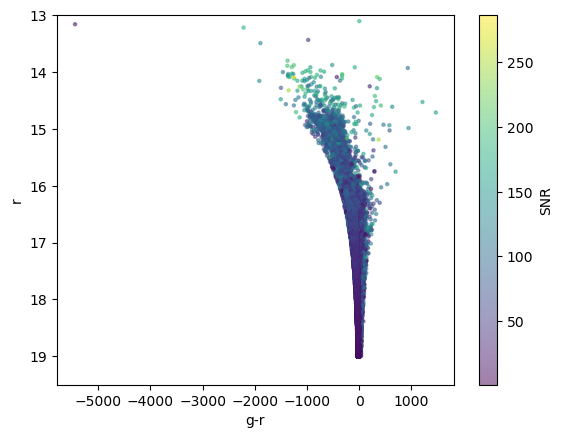

In [13]:
# r versus gmr, c is SNR

gmr_bright = color_gmr[bright_index]
mag_r_bright = mag_r[bright_index]
snr_bright = snr[bright_index]

r_limit_index = np.where((mag_r_bright<=19)&(snr_bright>0))

plt.scatter(gmr_bright[r_limit_index], mag_r_bright[r_limit_index], c=snr_bright[r_limit_index],
                    s=20, 
                    marker='.',
                    alpha =0.5,
                   cmap = 'viridis')
plt.xlabel('g-r')
plt.ylabel('r')
plt.ylim(19.5, 13)
#plt.xlim(-2,2)
plt.colorbar(label='SNR')

# TEST phase spiral with GAIA distances

In [ ]:
def phase_spiral_values(dist, ra, dec, pmra, pmdec, vrad, dist_min=0, dist_max=10):
    '''
    converts ra and dec coords to r,phi,z galactic coords
    inputs: 
            dist: distance object is from us in kpc
            ra: ra
            dec: dec
            pmra: ra proper motion 
            pmdec: dec proper motion
            vrad: line of sight velocity
            
            dist_min: min distance range
            dist_max: max distance range to be calulcat
    
    outputs: r,phi,z, and their respective velocities
    '''
    
    dist_index = np.where((dist<=dist_max) & (dist>dist_min))
    dist_cut = dist[dist_index]
    ra_cut = ra[dist_index]
    dec_cut = dec[dist_index]
    pmra_cut = pmra[dist_index]
    pmdec_cut = pmdec[dist_index]
    vrad_cut = vrad[dist_index]
    
    
    
    c= coord.ICRS(ra=ra_cut*u.deg,
              dec=dec_cut*u.deg,
                  distance=dist_cut*u.kpc,
                  pm_ra_cosdec=pmra_cut*u.mas/u.yr,
                  pm_dec=pmdec_cut*u.mas/u.yr,
                  radial_velocity=vrad_cut*u.km/u.s)
    
    # Define GC frame
    v_sun = coord.CartesianDifferential([11.1,245.,7.25]*u.km/u.s)
    gc_frame= coord.Galactocentric(galcen_distance=8.1*u.kpc,
                                       z_sun=25.*u.pc,
                                       galcen_v_sun=v_sun)
    cg= c.transform_to(gc_frame)

    cg.representation_type = 'cylindrical'
    
    r = cg.rho.to(u.kpc).value
    phi = cg.phi.degree
    z= cg.z.to(u.kpc).value
    v_r = cg.d_rho.to(u.km/u.s).value
    v_phi = (cg.d_phi*cg.rho).to(u.km/u.s,
            equivalencies=u.dimensionless_angles()).value
    v_z = cg.d_z.to(u.km/u.s).value
    
    
    return r, phi, z, v_r, v_phi, v_z


In [ ]:

dist = 1/parallax
parallax_err_index = np.where((dist>0) &(parallax_error/parallax <.2))
print(len(dist), len(dist[parallax_err_index]))
#plt.hist(dist[parallax_err_index])


# sort into bright and dark program
dist_bright = dist[bright_index]

# brights for parallax
parallax_bright = parallax[bright_index]
parallax_error_bright = parallax_error[bright_index]

ra_bright = ra[bright_index]
dec_bright = dec[bright_index]

mag_r_bright = mag_r[bright_index]

feh_bright = feh[bright_index]

############################################################################################
############################################################################################
############################################################################################

# need distance, proper motion, and vrad

# sort into bright and dark program
dist_bright = dist[bright_index] # kpc

pmra_bright = pmra[bright_index] # mas/yr
pmdec_bright = pmdec[bright_index]

vrad_bright = vrad[bright_index] # km/s # line of sight velocity

ra_bright = ra[bright_index]
dec_bright = dec[bright_index]

snr_bright = snr[bright_index]
feh_bright=feh[bright_index]

print(len(feh_bright), len(ra_bright), len(parallax_bright), len(pmra_bright))



In [ ]:
fig, ax = plt.subplots(1,figsize=(5,5))

parallax_err_index = np.where((dist_bright>0)&(parallax_error_bright/parallax_bright <.2))

r, phi, z, v_r, v_phi, v_z = phase_spiral_values(dist_bright[parallax_err_index],
                                                 ra_bright[parallax_err_index], dec_bright[parallax_err_index],
                                                 pmra_bright[parallax_err_index],
                                                 pmdec_bright[parallax_err_index], 
                                                 vrad_bright[parallax_err_index], dist_max = 10, dist_min=0)
ind500 = np.where(((abs(z))<=1.5)&(abs(phi)>160)&(abs(phi)<200)&(r>7.5)&(r<8.5)&(abs(v_z)<100)&
                  (v_phi<np.nanpercentile(v_phi, 70))&(v_phi>np.nanpercentile(v_phi, 30)))
pcm = ax.scatter(z[ind500], v_z[ind500],
            c = v_phi[ind500],
                s=10, 
                marker='.',
                alpha =0.5,
                cmap = 'jet_r')
ax.text(0.01, .99, 'R=8 kpc', ha='left', va='top', transform=ax.transAxes)
ax.set_xlabel('z [kpc]')
ax.set_ylabel('v_z [km/s]')
fig.colorbar(pcm, ax=ax, location='top', label='$v_\phi$  [km/s]')

In [ ]:
# binned
parallax_err_index = np.where((dist_bright>0)&(parallax_error_bright/parallax_bright <.2))

r, phi, z, v_r, v_phi, v_z = phase_spiral_values(dist_bright[parallax_err_index],
                                                 ra_bright[parallax_err_index], dec_bright[parallax_err_index],
                                                 pmra_bright[parallax_err_index],
                                                 pmdec_bright[parallax_err_index], 
                                                 vrad_bright[parallax_err_index], dist_max = 10, dist_min=0)
ind500 = np.where(((abs(z))<=1.5)&
                  (abs(phi)>160)&(abs(phi)<200)&
                  (r>7.5)&(r<8.5)& #8.24 kpc < R < 8.44
                  (abs(v_z)<100)&
                  (v_phi<np.nanpercentile(v_phi, 75))&(v_phi>np.nanpercentile(v_phi, 10)))
print(max(v_phi[ind500]), min(v_phi[ind500]))

bin_z_vz = scipy.stats.binned_statistic_2d(z[ind500], v_z[ind500], v_phi[ind500], 'median', bins=(200, 76))

fig, ax = plt.subplots(1,figsize=(6,4))

pcm = ax.imshow(bin_z_vz.statistic.T,
                origin='lower',norm = 'linear',
                cmap = 'magma', extent = [-1.5,1.5,-1,1])

y_label_list = np.array([-1,-.5,-0.75,-0.25,0,0.25,0.5,0.75,1])*100

ax.set_yticks([-1,-.5,-0.75,-0.25,0,0.25,0.5,0.75,1])

ax.set_yticklabels(y_label_list)

#ax.text(0.01, .99, 'R=8 kpc', ha='left', va='top', transform=ax.transAxes)
ax.set_xlabel('Z [kpc]')
ax.set_ylabel('$V_Z$ [km s$^{-1}$]')
fig.colorbar(pcm, ax=ax, location='top', label='$V_\phi$  [km s$^{-1}$]')

# connie's set up (aka just looking at brights)

In [ ]:
idxp,=np.where((rvtab["SURVEY"]=='main')&
                (rvtab["PROGRAM"]=='bright')&
                (rmag < 25.0) & # originally 19
                (rvtab['RVS_WARN'] == 0) &
                (rvtab['RR_SPECTYPE'] == 'STAR')&
                (rvtab['VSINI']<50)&
                (np.isnan(gmr)==0)&
                #(rvtab['LOGG']>4)& for photo
                #(rvtab['SN_R']>10)&
                (gaiatab['PARALLAX_ERROR']/gaiatab['PARALLAX']<0.2)&
                (gaiatab['PARALLAX_ERROR']/gaiatab['PARALLAX']>0))

In [ ]:
print(len(iprim), len(idxp)) # difference is SNR

In [ ]:
# column data in numpy array form with the cuts
ra = np.array(df_rvtab['TARGET_RA'][idxp])
dec = np.array(df_rvtab['TARGET_DEC'][idxp])
feh = np.array(df_rvtab['FEH'][idxp])
teff = np.array(df_rvtab['TEFF'][idxp])
vrad = np.array(df_rvtab['VRAD'][idxp]) # km/s
snr = np.array(df_rvtab['SN_R'][idxp])

survey = np.array(df_rvtab['SURVEY'][idxp])
program = np.array(df_rvtab['PROGRAM'][idxp])
alphafe_err = np.array(df_rvtab['ALPHAFE_ERR'][idxp])
feh_err = np.array(df_rvtab['FEH_ERR'][idxp])

#ref_cat = np.array(df_rvtab['REF_CAT'][iprim])
#ref_id = np.array(df_rvtab['REF_ID'][iprim])

pmra = np.array(df_gaia['PMRA'][idxp]) # milli arcsec /yr
pmdec = np.array(df_gaia['PMDEC'][idxp])
parallax = np.array(df_gaia["PARALLAX"][idxp])
parallax_error = np.array(df_gaia["PARALLAX_ERROR"][idxp])
color_gmr = np.array(df_fmap['FLUX_G'][idxp] - df_fmap['FLUX_R'][idxp])
mag_g = np.array(-2.5*np.log10(df_fmap['FLUX_G'][idxp])+22.5)
mag_r = np.array(rmag[idxp])
mag_r_index = np.where((mag_r>17)&(mag_r<17.25))

dist = 1/parallax # kpc

In [ ]:
print(len(dist), len(r))

In [ ]:
r, phi, z, v_r, v_phi, v_z = phase_spiral_values(dist,
                                                 ra, dec,
                                                 pmra,
                                                 pmdec, 
                                                 vrad, dist_max = 16., dist_min=0.)
ind500 = np.where((z>0.)&(z<=.25)&
                  (abs(phi)>170)&(abs(phi)<190)&
                  (r>5)&(r<10)&
                  (abs(v_z)<100)&
                  (v_phi<np.nanpercentile(v_phi, 90.))&(v_phi>np.nanpercentile(v_phi, 1.)))

plt.hist(r, bins=50, label='r')
#plt.hist(phi, bins=50, alpha=0.7, label='phi')
plt.hist(z, bins=50, alpha=0.7, label='z')
plt.yscale('log')
plt.legend()
plt.show()

plt.hist(phi, bins=50, alpha=0.7, label='phi')
plt.yscale('log')
plt.show()

In [ ]:
plt.hist(dist, bins=30)
print(max(dist))

# z, V_Z

In [ ]:
fig, ax = plt.subplots(1,figsize=(5,5))


r, phi, z, v_r, v_phi, v_z = phase_spiral_values(dist,
                                                 ra, dec,
                                                 pmra,
                                                 pmdec, 
                                                 vrad, dist_max = 10, dist_min=0)
ind500 = np.where(((abs(z))<=1.5)&
                  (abs(phi)>160)&(abs(phi)<200)&
                  (r>7.5)&(r<8.5)& #8.24 kpc < R < 8.44
                  (abs(v_z)<100)&
                  (v_phi<np.nanpercentile(v_phi, 75))&(v_phi>np.nanpercentile(v_phi, 10)))

pcm = ax.scatter(z[ind500], v_z[ind500],
            c = v_phi[ind500],
                s=10, 
                marker='.',
                alpha =0.5,
                cmap = 'jet_r')
ax.text(0.01, .99, 'R=8 kpc', ha='left', va='top', transform=ax.transAxes)
ax.set_xlabel('z [kpc]')
ax.set_ylabel('v_z [km/s]')
fig.colorbar(pcm, ax=ax, location='top', label='$v_\phi$  [km/s]')

In [ ]:
r, phi, z, v_r, v_phi, v_z = phase_spiral_values(dist,
                                                 ra, dec,
                                                 pmra,
                                                 pmdec, 
                                                 vrad, dist_max = 13, dist_min=0)
ind500 = np.where(((abs(z))<=1.5)&
                  (abs(phi)>160)&(abs(phi)<200)&
                  (r>7.5)&(r<8.5)& #8.24 kpc < R < 8.44
                  (abs(v_z)<100)&
                  (v_phi<np.nanpercentile(v_phi, 75))&(v_phi>np.nanpercentile(v_phi, 10)))
print(max(v_phi[ind500]), min(v_phi[ind500]))

bin_z_vz = scipy.stats.binned_statistic_2d(z[ind500], v_z[ind500], v_phi[ind500], 'median', bins=(200, 76))

fig, ax = plt.subplots(1,figsize=(6,4))

pcm = ax.imshow(bin_z_vz.statistic.T,
                origin='lower',norm = 'linear',
                cmap = 'magma', extent = [-1.5,1.5,-1,1])

y_label_list = np.array([-1,-.5,-0.75,-0.25,0,0.25,0.5,0.75,1])*100

ax.set_yticks([-1,-.5,-0.75,-0.25,0,0.25,0.5,0.75,1])

ax.set_yticklabels(y_label_list)

#ax.text(0.01, .99, 'R=8 kpc', ha='left', va='top', transform=ax.transAxes)
ax.set_xlabel('Z [kpc]')
ax.set_ylabel('$V_Z$ [km s$^{-1}$]')
fig.colorbar(pcm, ax=ax, location='top', label='$V_\phi$  [km s$^{-1}$]')

#fig.savefig('./z_vz_phase_spiral_diagram.png', dpi=400)



In [ ]:
# binning figure out total difference (max and min) then divide by the delta.. spacing you want
# to get the number of bins

max(v_z[ind500])-min(v_z[ind500])

# R, V_phi

In [ ]:
fig, ax = plt.subplots(1,figsize=(5,5))


r, phi, z, v_r, v_phi, v_z = phase_spiral_values(dist,
                                                 ra, dec,
                                                 pmra,
                                                 pmdec, 
                                                 vrad, dist_max = 10, dist_min=0)
ind500 = np.where(((abs(z))<=1.5)&(abs(phi)>160)&(abs(phi)<200)&(r>5.5)&(r<10.5)&(abs(v_z)<100)&
                  (v_phi<np.nanpercentile(v_phi, 70))&(v_phi>np.nanpercentile(v_phi, 30)))
pcm = ax.scatter(r[ind500], v_phi[ind500],
            c = v_phi[ind500],
                s=10, 
                marker='.',
                alpha =0.5,
                cmap = 'jet_r')
#ax.text(0.01, .99, 'R=8 kpc', ha='left', va='top', transform=ax.transAxes)
ax.set_xlabel('r [kpc]')
ax.set_ylabel('v_phi [km/s]')
fig.colorbar(pcm, ax=ax, location='top', label='$v_\phi$  [km/s]')


print(min(v_phi[ind500]), max(v_phi[ind500]))

## test with bin.stat_2d

In [ ]:
r, phi, z, v_r, v_phi, v_z = phase_spiral_values(dist,
                                                 ra, dec,
                                                 pmra,
                                                 pmdec, 
                                                 vrad, dist_max = 12, dist_min=0)
ind500 = np.where(((abs(z))<=2.)&
                  (abs(phi)>170)&(abs(phi)<190)
                  &(r>5.5)&(r<10.5)&
                  (abs(v_z)<100)&
                  (v_phi<np.nanpercentile(v_phi, 90))&(v_phi>np.nanpercentile(v_phi, 1)))


bin_r_vphi = scipy.stats.binned_statistic_2d(r[ind500], -v_phi[ind500], None, 'count', bins=(704,129))

fig, ax = plt.subplots(1,figsize=(5,5))

pcm = ax.imshow(bin_r_vphi.statistic.T,
                origin='lower',
                cmap = 'magma_r',
                norm = 'linear',
                #vmax = 70,
                extent=[-1.5,1.5,-1,1])


x_label_list = np.array([5.5,6.75,8.0,9.25,10.5])
ax.set_xticks([-1.5,-0.75,0,0.75,1.5])
ax.set_xticklabels(x_label_list)

#y_label_list = np.array([-230,-217.5,-205,-192.5,-180])
#ax.set_yticks([-1,-.5,0,0.5,1])
#ax.set_yticklabels(y_label_list)

ax.set_xlabel('r [kpc]')
ax.set_ylabel('$v_\phi$ [km/s]')
fig.colorbar(pcm, ax=ax, location='top', label='count')

## distances plots: go out to different distances

In [ ]:
fig, ax = plt.subplots(1,4, figsize=(18,5))

r, phi, z, v_r, v_phi, v_z = phase_spiral_values(dist,
                                                 ra, dec,
                                                 pmra,
                                                 pmdec, 
                                                 vrad, dist_max = .5, dist_min=0.)
ind500 = np.where(((abs(z))<=1.)&
                  (abs(phi)>170)&(abs(phi)<190)
                  &(r>5.5)&(r<10.5)&
                  (abs(v_z)<100)&
                  (v_phi<np.nanpercentile(v_phi, 90))&(v_phi>np.nanpercentile(v_phi, 1)))

'''
bin_r_vphi = scipy.stats.binned_statistic_2d(r[ind500], -v_phi[ind500], None, 'count', bins=(704,129))

pcm = ax[0].imshow(bin_r_vphi.statistic.T,
                origin='lower',
                cmap = 'magma_r',
                norm = 'linear',
                #vmax = 70,
                extent=[-1.5,1.5,-1,1])
'''
binning = [2*int((max(r[ind500])-min(r[ind500]))/0.01), int((max(-v_phi[ind500])-min(-v_phi[ind500])))]
print(binning)
im = ax[0].hist2d(r[ind500],  -v_phi[ind500], bins=[418, 135], cmap='magma_r')
ax[0].set_xlabel('R')


#x_label_list = np.array([5.5,6.75,8.0,9.25,10.5])
#ax[0].set_xticks([-1.5,-0.75,0,0.75,1.5])
#ax[0].set_xticklabels(x_label_list)

#y_label_list = np.array([-230,-217.5,-205,-192.5,-180])
#ax.set_yticks([-1,-.5,0,0.5,1])
#ax.set_yticklabels(y_label_list)

ax[0].set_xlabel('r [kpc]')
ax[0].set_ylabel('$v_\phi$ [km/s]')
ax[0].text(0.01, .99, 'D: 0-0.5 kpc', ha='left', va='top', transform=ax[0].transAxes)
fig.colorbar(im[3], ax=ax[0], location='top', label='count')


###############################################################################
###############################################################################
###############################################################################

r, phi, z, v_r, v_phi, v_z = phase_spiral_values(dist,
                                                 ra, dec,
                                                 pmra,
                                                 pmdec, 
                                                 vrad, dist_max = 1., dist_min=0.)
ind500 = np.where(((abs(z))<=1.)&
                  (abs(phi)>170)&(abs(phi)<190)
                  &(r>5.5)&(r<10.5)&
                  (abs(v_z)<100)&
                  (v_phi<np.nanpercentile(v_phi, 90))&(v_phi>np.nanpercentile(v_phi, 1)))

'''
bin_r_vphi = scipy.stats.binned_statistic_2d(r[ind500], -v_phi[ind500], None, 'count', bins=(704,129))

pcm = ax[1].imshow(bin_r_vphi.statistic.T,
                origin='lower',
                cmap = 'magma_r',
                norm = 'linear',
                #vmax = 70,
                extent=[-1.5,1.5,-1,1])
'''

binning = [int((max(r[ind500])-min(r[ind500]))/0.01), int((max(-v_phi[ind500])-min(-v_phi[ind500])))]
print(binning)


im = ax[1].hist2d(r[ind500],  -v_phi[ind500], bins=[418, 135], cmap='magma_r')
ax[1].set_xlabel('R')


#x_label_list = np.array([5.5,6.75,8.0,9.25,10.5])
#ax[1].set_xticks([-1.5,-0.75,0,0.75,1.5])
#ax[1].set_xticklabels(x_label_list)

#y_label_list = np.array([-230,-217.5,-205,-192.5,-180])
#ax.set_yticks([-1,-.5,0,0.5,1])
#ax.set_yticklabels(y_label_list)

ax[1].set_xlabel('r [kpc]')
ax[1].set_ylabel('$v_\phi$ [km/s]')
ax[1].text(0.01, .99, 'D: 0-1 kpc', ha='left', va='top', transform=ax[1].transAxes)
fig.colorbar(im[3], ax=ax[1], location='top', label='count')

###############################################################################
###############################################################################
###############################################################################


r, phi, z, v_r, v_phi, v_z = phase_spiral_values(dist,
                                                 ra, dec,
                                                 pmra,
                                                 pmdec, 
                                                 vrad, dist_max = 2., dist_min=0.)
ind500 = np.where(((abs(z))<=1.)&
                  (abs(phi)>170)&(abs(phi)<190)
                  &(r>5.5)&(r<10.5)&
                  (abs(v_z)<100)&
                  (v_phi<np.nanpercentile(v_phi, 90.))&(v_phi>np.nanpercentile(v_phi, 1.)))

'''
bin_r_vphi = scipy.stats.binned_statistic_2d(r[ind500], -v_phi[ind500], None, 'count', bins=(704,129))

pcm = ax[2].imshow(bin_r_vphi.statistic.T,
                origin='lower',
                cmap = 'magma_r',
                norm = 'linear',
                #vmax = 70,
                extent=[-1.5,1.5,-1,1])
'''

binning = [int((max(r[ind500])-min(r[ind500]))/0.01), int((max(-v_phi[ind500])-min(-v_phi[ind500])))]
print(binning)


im = ax[2].hist2d(r[ind500],  -v_phi[ind500], bins=binning, cmap='magma_r')
ax[2].set_xlabel('R')


#x_label_list = np.array([5.5,6.75,8.0,9.25,10.5])
#ax[2].set_xticks([-1.5,-0.75,0,0.75,1.5])
#ax[2].set_xticklabels(x_label_list)

#y_label_list = np.array([-230,-217.5,-205,-192.5,-180])
#ax.set_yticks([-1,-.5,0,0.5,1])
#ax.set_yticklabels(y_label_list)

ax[2].set_xlabel('r [kpc]')
ax[2].set_ylabel('$v_\phi$ [km/s]')
ax[2].text(0.01, .99, 'D: 0-2 kpc', ha='left', va='top', transform=ax[2].transAxes)
fig.colorbar(im[3], ax=ax[2], location='top', label='count')



###############################################################################
###############################################################################
###############################################################################


r, phi, z, v_r, v_phi, v_z = phase_spiral_values(dist,
                                                 ra, dec,
                                                 pmra,
                                                 pmdec, 
                                                 vrad, dist_max = 12., dist_min=0.)
ind500 = np.where(((abs(z))<=1.)&
                  (abs(phi)>170)&(abs(phi)<190)
                  &(r>5.5)&(r<10.5)&
                  (abs(v_z)<100)&
                  (v_phi<np.nanpercentile(v_phi, 90.))&(v_phi>np.nanpercentile(v_phi, 1.)))

'''
bin_r_vphi = scipy.stats.binned_statistic_2d(r[ind500], -v_phi[ind500], None, 'count', bins=(704,129))

pcm = ax[2].imshow(bin_r_vphi.statistic.T,
                origin='lower',
                cmap = 'magma_r',
                norm = 'linear',
                #vmax = 70,
                extent=[-1.5,1.5,-1,1])
'''

binning = [int((max(r[ind500])-min(r[ind500]))/0.01), int((max(-v_phi[ind500])-min(-v_phi[ind500])))]
print(binning)


im = ax[3].hist2d(r[ind500],  -v_phi[ind500], bins=binning, cmap='magma_r')
ax[3].set_xlabel('R')


#x_label_list = np.array([5.5,6.75,8.0,9.25,10.5])
#ax[2].set_xticks([-1.5,-0.75,0,0.75,1.5])
#ax[2].set_xticklabels(x_label_list)

#y_label_list = np.array([-230,-217.5,-205,-192.5,-180])
#ax.set_yticks([-1,-.5,0,0.5,1])
#ax.set_yticklabels(y_label_list)

ax[3].set_xlabel('r [kpc]')
ax[3].set_ylabel('$v_\phi$ [km/s]')
ax[3].text(0.01, .99, 'D: 0-12 kpc', ha='left', va='top', transform=ax[3].transAxes)
fig.colorbar(im[3], ax=ax[3], location='top', label='count')

#fig.savefig('./plots/r_v_phi_different_ending_dist.png', dpi=300)





## distances plots: start from different distances

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(18,5))

r, phi, z, v_r, v_phi, v_z = phase_spiral_values(dist,
                                                 ra, dec,
                                                 pmra,
                                                 pmdec, 
                                                 vrad, dist_max = 12, dist_min=0.)
ind500 = np.where(((abs(z))<=1.)&
                  (abs(phi)>170)&(abs(phi)<190)
                  &(r>5.5)&(r<10.5)&
                  (abs(v_z)<100)&
                  (v_phi<np.nanpercentile(v_phi, 90))&(v_phi>np.nanpercentile(v_phi, 1)))

'''
bin_r_vphi = scipy.stats.binned_statistic_2d(r[ind500], -v_phi[ind500], None, 'count', bins=(704,129))

pcm = ax[0].imshow(bin_r_vphi.statistic.T,
                origin='lower',
                cmap = 'magma_r',
                norm = 'linear',
                #vmax = 70,
                extent=[-1.5,1.5,-1,1])
'''

im = ax[0].hist2d(r[ind500],  -v_phi[ind500], bins=[418, 135], cmap='magma_r')
ax[0].set_xlabel('R')


#x_label_list = np.array([5.5,6.75,8.0,9.25,10.5])
#ax[0].set_xticks([-1.5,-0.75,0,0.75,1.5])
#ax[0].set_xticklabels(x_label_list)

#y_label_list = np.array([-230,-217.5,-205,-192.5,-180])
#ax.set_yticks([-1,-.5,0,0.5,1])
#ax.set_yticklabels(y_label_list)

ax[0].set_xlabel('r [kpc]')
ax[0].set_ylabel('$v_\phi$ [km/s]')
ax[0].text(0.01, .99, 'D: 0-12 kpc', ha='left', va='top', transform=ax[0].transAxes)
fig.colorbar(im[3], ax=ax[0], location='top', label='count')


###############################################################################
###############################################################################
###############################################################################

r, phi, z, v_r, v_phi, v_z = phase_spiral_values(dist,
                                                 ra, dec,
                                                 pmra,
                                                 pmdec, 
                                                 vrad, dist_max = 12, dist_min=0.5)
ind500 = np.where(((abs(z))<=1.)&
                  (abs(phi)>170)&(abs(phi)<190)
                  &(r>5.5)&(r<10.5)&
                  (abs(v_z)<100)&
                  (v_phi<np.nanpercentile(v_phi, 90))&(v_phi>np.nanpercentile(v_phi, 1)))

'''
bin_r_vphi = scipy.stats.binned_statistic_2d(r[ind500], -v_phi[ind500], None, 'count', bins=(704,129))

pcm = ax[1].imshow(bin_r_vphi.statistic.T,
                origin='lower',
                cmap = 'magma_r',
                norm = 'linear',
                #vmax = 70,
                extent=[-1.5,1.5,-1,1])
'''

binning = [int((max(r[ind500])-min(r[ind500]))/0.01), int((max(-v_phi[ind500])-min(-v_phi[ind500])))]
print(binning)


im = ax[1].hist2d(r[ind500],  -v_phi[ind500], bins=[418, 135], cmap='magma_r')
ax[1].set_xlabel('R')


#x_label_list = np.array([5.5,6.75,8.0,9.25,10.5])
#ax[1].set_xticks([-1.5,-0.75,0,0.75,1.5])
#ax[1].set_xticklabels(x_label_list)

#y_label_list = np.array([-230,-217.5,-205,-192.5,-180])
#ax.set_yticks([-1,-.5,0,0.5,1])
#ax.set_yticklabels(y_label_list)

ax[1].set_xlabel('r [kpc]')
ax[1].set_ylabel('$v_\phi$ [km/s]')
ax[1].text(0.01, .99, 'D: 0.5-12 kpc', ha='left', va='top', transform=ax[1].transAxes)
fig.colorbar(im[3], ax=ax[1], location='top', label='count')

###############################################################################
###############################################################################
###############################################################################


r, phi, z, v_r, v_phi, v_z = phase_spiral_values(dist,
                                                 ra, dec,
                                                 pmra,
                                                 pmdec, 
                                                 vrad, dist_max = 12., dist_min=1.)
ind500 = np.where(((abs(z))<=1.)&
                  (abs(phi)>170)&(abs(phi)<190)
                  &(r>5.5)&(r<10.5)&
                  (abs(v_z)<100)&
                  (v_phi<np.nanpercentile(v_phi, 90.))&(v_phi>np.nanpercentile(v_phi, 1.)))

'''
bin_r_vphi = scipy.stats.binned_statistic_2d(r[ind500], -v_phi[ind500], None, 'count', bins=(704,129))

pcm = ax[2].imshow(bin_r_vphi.statistic.T,
                origin='lower',
                cmap = 'magma_r',
                norm = 'linear',
                #vmax = 70,
                extent=[-1.5,1.5,-1,1])
'''

binning = [int((max(r[ind500])-min(r[ind500]))/0.01), int((max(-v_phi[ind500])-min(-v_phi[ind500])))]
print(binning)


im = ax[2].hist2d(r[ind500],  -v_phi[ind500], bins=[418, 135], cmap='magma_r')
ax[2].set_xlabel('R')

#x_label_list = np.array([5.5,6.75,8.0,9.25,10.5])
#ax[2].set_xticks([-1.5,-0.75,0,0.75,1.5])
#ax[2].set_xticklabels(x_label_list)

#y_label_list = np.array([-230,-217.5,-205,-192.5,-180])
#ax.set_yticks([-1,-.5,0,0.5,1])
#ax.set_yticklabels(y_label_list)

ax[2].set_xlabel('r [kpc]')
ax[2].set_ylabel('$v_\phi$ [km/s]')
ax[2].text(0.01, .99, 'D: 1-12 kpc', ha='left', va='top', transform=ax[2].transAxes)
fig.colorbar(im[3], ax=ax[2], location='top', label='count')

#fig.savefig('./plots/r_v_phi_different_starting_dist.png', dpi=300)


# different Z

In [ ]:
def plotting(r, v_phi, z, index, binning, ax_i):
    
    row,col = ax_i
    
    bin_r_vphi = scipy.stats.binned_statistic_2d(r[index], -v_phi[index], None, 'count', bins=(binning[0],binning[1]))

    image = bin_r_vphi[0].T # transpose to make (r, v_phi)

    #print(len(image[:,0]))

    image_col_mean = np.copy(image)
    for i in range(len(image[1])): # column length
        image_col_mean[:,i] = image[:,i] - np.median(image[:,i])

    pcm = ax[row, col].imshow(image_col_mean,
                    origin='lower',
                    cmap = 'magma_r',
                    norm = 'linear',
                    #vmax = 60,
                    vmin=-0,
                    extent=[-1.5,1.5,-1,1]
                   )

    x_label_list = np.array([np.round(min(r[index])),np.round(np.median(r[index])),np.round(max(r[index]))])
    ax[row, col].set_xticks([-1.5,0.,1.5])
    ax[row, col].set_xticklabels(x_label_list)
    ax[row, col].set_xlabel('R [kpc]')


    y_label_list = np.array([np.round(min(-v_phi[index])),np.round(np.median(-v_phi[index])),np.round(max(-v_phi[index]))])
    ax[row, col].set_yticks([-1,0,1])
    ax[row, col].set_yticklabels(y_label_list)
    ax[row, col].set_ylabel('$v_\phi$ [km/s]')
    z_min_max = [np.round(min(z[index]), 2),np.round(max(z[index]), 2)]
    ax[row, col].text(0.01, .99, 'z = %s' %z_min_max, ha='left', va='top', transform=ax[row, col].transAxes)
    fig.colorbar(pcm, ax=ax[row, col], location='top', label='count')



In [ ]:
fig, ax = plt.subplots(2,5, figsize=(28,9))

delta_r = 0.05

r, phi, z, v_r, v_phi, v_z = phase_spiral_values(dist,
                                                 ra, dec,
                                                 pmra,
                                                 pmdec, 
                                                 vrad, dist_max = 16., dist_min=0.)
ind500 = np.where((z>0.)&(z<=.25)&
                  (abs(phi)>170)&(abs(phi)<190)&
                  (r>5)&(r<10)&
                  (abs(v_z)<100)&
                  (v_phi<np.nanpercentile(v_phi, 90.))&(v_phi>np.nanpercentile(v_phi, 1.)))
binning = [int((max(r[ind500])-min(r[ind500]))/delta_r), int((max(-v_phi[ind500])-min(-v_phi[ind500])))]
#print(binning)
binning = [100, 100]
ax_i = np.array([0,0])
plotting(r, v_phi, z, ind500, binning, ax_i)

########################################################################################################
########################################################################################################

ind500 = np.where((z>0.25)&(z<=.5)&
                  (abs(phi)>170)&(abs(phi)<190)&
                  (r>5)&(r<10)&
                  (abs(v_z)<100)&
                  (v_phi<np.nanpercentile(v_phi, 90.))&(v_phi>np.nanpercentile(v_phi, 1.)))
binning = [int((max(r[ind500])-min(r[ind500]))/delta_r), int((max(-v_phi[ind500])-min(-v_phi[ind500])))]
#print(binning)
binning = [100, 100]
ax_i = np.array([0,1])
plotting(r, v_phi, z, ind500, binning, ax_i)

########################################################################################################
########################################################################################################

ind500 = np.where((z>0.5)&(z<=1.0)&
                  (abs(phi)>170)&(abs(phi)<190)&
                  (r>5)&(r<10)&
                  (abs(v_z)<100)&
                  (v_phi<np.nanpercentile(v_phi, 90.))&(v_phi>np.nanpercentile(v_phi, 1.)))
binning = [int((max(r[ind500])-min(r[ind500]))/delta_r), int((max(-v_phi[ind500])-min(-v_phi[ind500])))]
#print(binning)
binning = [100, 100]
ax_i = np.array([0,2])
plotting(r, v_phi, z, ind500, binning, ax_i)


########################################################################################################
########################################################################################################

ind500 = np.where((z>1.)&(z<=2.0)&
                  (abs(phi)>170)&(abs(phi)<190)&
                  (r>5)&(r<10)&
                  (abs(v_z)<100)&
                  (v_phi<np.nanpercentile(v_phi, 90.))&(v_phi>np.nanpercentile(v_phi, 1.)))
binning = [int((max(r[ind500])-min(r[ind500]))/delta_r), int((max(-v_phi[ind500])-min(-v_phi[ind500])))]
#print(binning)
binning = [100, 100]
ax_i = np.array([0,3])
plotting(r, v_phi, z, ind500, binning, ax_i)

########################################################################################################
########################################################################################################

ind500 = np.where((z>2.)&
                  (abs(phi)>170)&(abs(phi)<190)&
                  (r>5)&(r<10)&
                  (abs(v_z)<100)&
                  (v_phi<np.nanpercentile(v_phi, 90.))&(v_phi>np.nanpercentile(v_phi, 1.)))
binning = [int((max(r[ind500])-min(r[ind500]))/delta_r), int((max(-v_phi[ind500])-min(-v_phi[ind500])))]
#print(binning)
binning = [100, 100]
ax_i = np.array([0,4])
plotting(r, v_phi, z, ind500, binning, ax_i)

########################################################################################################
########################################################################################################
########################################################################################################
########################################################################################################
########################################################################################################
########################################################################################################
########################################################################################################
########################################################################################################

ind500 = np.where((z>0.)&(z<=.25)&
                  #(abs(phi)>170)&(abs(phi)<190)&
                  (r>5)&(r<10)&
                  (abs(v_z)<100)&
                  (v_phi<np.nanpercentile(v_phi, 90.))&(v_phi>np.nanpercentile(v_phi, 1.)))
binning = [int((max(r[ind500])-min(r[ind500]))/delta_r), int((max(-v_phi[ind500])-min(-v_phi[ind500])))]
#print(binning)
binning = [100, 100]
ax_i = np.array([1,0])
plotting(r, v_phi, z, ind500, binning, ax_i)

########################################################################################################
########################################################################################################

ind500 = np.where((z>0.25)&(z<=.5)&
                  #(abs(phi)>170)&(abs(phi)<190)&
                  (r>5)&(r<10)&
                  (abs(v_z)<100)&
                  (v_phi<np.nanpercentile(v_phi, 90.))&(v_phi>np.nanpercentile(v_phi, 1.)))
binning = [int((max(r[ind500])-min(r[ind500]))/delta_r), int((max(-v_phi[ind500])-min(-v_phi[ind500])))]
#print(binning)
binning = [100, 100]
ax_i = np.array([1,1])
plotting(r, v_phi, z, ind500, binning, ax_i)

########################################################################################################
########################################################################################################

ind500 = np.where((z>0.5)&(z<=1.0)&
                  #(abs(phi)>170)&(abs(phi)<190)&
                  (r>5)&(r<10)&
                  (abs(v_z)<100)&
                  (v_phi<np.nanpercentile(v_phi, 90.))&(v_phi>np.nanpercentile(v_phi, 1.)))
binning = [int((max(r[ind500])-min(r[ind500]))/delta_r), int((max(-v_phi[ind500])-min(-v_phi[ind500])))]
#print(binning)
binning = [100, 100]
ax_i = np.array([1,2])
plotting(r, v_phi, z, ind500, binning, ax_i)


########################################################################################################
########################################################################################################

ind500 = np.where((z>1.)&(z<=2.0)&
                  #(abs(phi)>170)&(abs(phi)<190)&
                  (r>5)&(r<10)&
                  (abs(v_z)<100)&
                  (v_phi<np.nanpercentile(v_phi, 90.))&(v_phi>np.nanpercentile(v_phi, 1.)))
binning = [int((max(r[ind500])-min(r[ind500]))/delta_r), int((max(-v_phi[ind500])-min(-v_phi[ind500])))]
#print(binning)
binning = [100, 100]
ax_i = np.array([1,3])
plotting(r, v_phi, z, ind500, binning, ax_i)

########################################################################################################
########################################################################################################

ind500 = np.where((z>2.)&
                  #(abs(phi)>170)&(abs(phi)<190)&
                  (r>5)&(r<10)&
                  (abs(v_z)<100)&
                  (v_phi<np.nanpercentile(v_phi, 90.))&(v_phi>np.nanpercentile(v_phi, 1.)))
binning = [int((max(r[ind500])-min(r[ind500]))/delta_r), int((max(-v_phi[ind500])-min(-v_phi[ind500])))]
#print(binning)
binning = [100, 100]
ax_i = np.array([1,4])
plotting(r, v_phi, z, ind500, binning, ax_i)


#fig.savefig("./different_z.png", dpi=400)

plt.show()


# mapping to z

In [ ]:
fig, ax = plt.subplots(2,5, figsize=(28,9))

delta_r = 0.05

r, phi, z, v_r, v_phi, v_z = phase_spiral_values(dist,
                                                 ra, dec,
                                                 pmra,
                                                 pmdec, 
                                                 vrad, dist_max = 16., dist_min=0.)
ind500 = np.where((z>0.)&(z<=.25)&
                  (abs(phi)>170)&(abs(phi)<190)&
                  (r>5)&(r<10)&
                  (abs(v_z)<100)&
                  (v_phi<np.nanpercentile(v_phi, 90.))&(v_phi>np.nanpercentile(v_phi, 1.)))
binning = [int((max(r[ind500])-min(r[ind500]))/delta_r), int((max(-v_phi[ind500])-min(-v_phi[ind500])))]
#print(binning)
binning = [100, 100]
ax_i = np.array([0,0])
plotting(r, v_phi, z, ind500, binning, ax_i)

########################################################################################################
########################################################################################################

ind500 = np.where((z>0.25)&(z<=.5)&
                  (abs(phi)>170)&(abs(phi)<190)&
                  (r>5)&(r<10)&
                  (abs(v_z)<100)&
                  (v_phi<np.nanpercentile(v_phi, 90.))&(v_phi>np.nanpercentile(v_phi, 1.)))
binning = [int((max(r[ind500])-min(r[ind500]))/delta_r), int((max(-v_phi[ind500])-min(-v_phi[ind500])))]
#print(binning)
binning = [100, 100]
ax_i = np.array([0,1])
plotting(r, v_phi, z, ind500, binning, ax_i)

########################################################################################################
########################################################################################################

ind500 = np.where((z>0.5)&(z<=1.0)&
                  (abs(phi)>170)&(abs(phi)<190)&
                  (r>5)&(r<10)&
                  (abs(v_z)<100)&
                  (v_phi<np.nanpercentile(v_phi, 90.))&(v_phi>np.nanpercentile(v_phi, 1.)))
binning = [int((max(r[ind500])-min(r[ind500]))/delta_r), int((max(-v_phi[ind500])-min(-v_phi[ind500])))]
#print(binning)
binning = [100, 100]
ax_i = np.array([0,2])
plotting(r, v_phi, z, ind500, binning, ax_i)


########################################################################################################
########################################################################################################

ind500 = np.where((z>1.)&(z<=2.0)&
                  (abs(phi)>170)&(abs(phi)<190)&
                  (r>5)&(r<10)&
                  (abs(v_z)<100)&
                  (v_phi<np.nanpercentile(v_phi, 90.))&(v_phi>np.nanpercentile(v_phi, 1.)))
binning = [int((max(r[ind500])-min(r[ind500]))/delta_r), int((max(-v_phi[ind500])-min(-v_phi[ind500])))]
#print(binning)
binning = [100, 100]
ax_i = np.array([0,3])
plotting(r, v_phi, z, ind500, binning, ax_i)

########################################################################################################
########################################################################################################

ind500 = np.where((z>2.)&
                  (abs(phi)>170)&(abs(phi)<190)&
                  (r>5)&(r<10)&
                  (abs(v_z)<100)&
                  (v_phi<np.nanpercentile(v_phi, 90.))&(v_phi>np.nanpercentile(v_phi, 1.)))
binning = [int((max(r[ind500])-min(r[ind500]))/delta_r), int((max(-v_phi[ind500])-min(-v_phi[ind500])))]
#print(binning)
binning = [100, 100]
ax_i = np.array([0,4])
plotting(r, v_phi, z, ind500, binning, ax_i)

########################################################################################################
########################################################################################################
########################################################################################################
########################################################################################################
########################################################################################################
########################################################################################################
########################################################################################################
########################################################################################################


def plotting_z_map(r, v_phi, z, index, binning, ax_i):
    
    row,col = ax_i
    
    bin_r_vphi = scipy.stats.binned_statistic_2d(r[index], -v_phi[index], z[index], 'median', bins=(binning[0],binning[1]))

    image = bin_r_vphi[0].T # transpose to make (r, v_phi)

    #print(len(image[:,0]))

    image_col_mean = np.copy(image)
    for i in range(len(image[1])): # column length
        image_col_mean[:,i] = image[:,i] - np.median(image[:,i])

    pcm = ax[row, col].imshow(image_col_mean,
                    origin='lower',
                    cmap = 'magma_r',
                    norm = 'linear',
                    #vmax = 60,
                    #vmin=-0,
                    extent=[-1.5,1.5,-1,1]
                   )

    x_label_list = np.array([np.round(min(r[index])),np.round(np.median(r[index])),np.round(max(r[index]))])
    ax[row, col].set_xticks([-1.5,0.,1.5])
    ax[row, col].set_xticklabels(x_label_list)
    ax[row, col].set_xlabel('R [kpc]')


    y_label_list = np.array([np.round(min(-v_phi[index])),np.round(np.median(-v_phi[index])),np.round(max(-v_phi[index]))])
    ax[row, col].set_yticks([-1,0,1])
    ax[row, col].set_yticklabels(y_label_list)
    ax[row, col].set_ylabel('$v_\phi$ [km/s]')
    z_min_max = [np.round(min(z[index]), 2),np.round(max(z[index]), 2)]
    ax[row, col].text(0.01, .99, 'z = %s' %z_min_max, ha='left', va='top', transform=ax[row, col].transAxes)
    fig.colorbar(pcm, ax=ax[row, col], location='top', label='z normalized')


    
    

ind500 = np.where((z>0.)&(z<=.25)&
                  #(abs(phi)>170)&(abs(phi)<190)&
                  (r>5)&(r<10)&
                  (abs(v_z)<100)&
                  (v_phi<np.nanpercentile(v_phi, 90.))&(v_phi>np.nanpercentile(v_phi, 1.)))
binning = [int((max(r[ind500])-min(r[ind500]))/delta_r), int((max(-v_phi[ind500])-min(-v_phi[ind500])))]
#print(binning)
binning = [50,30]
ax_i = np.array([1,0])
plotting_z_map(r, v_phi, z, ind500, binning, ax_i)

########################################################################################################
########################################################################################################

ind500 = np.where((z>0.25)&(z<=.5)&
                  #(abs(phi)>170)&(abs(phi)<190)&
                  (r>5)&(r<10)&
                  (abs(v_z)<100)&
                  (v_phi<np.nanpercentile(v_phi, 90.))&(v_phi>np.nanpercentile(v_phi, 1.)))
binning = [int((max(r[ind500])-min(r[ind500]))/delta_r), int((max(-v_phi[ind500])-min(-v_phi[ind500])))]
#print(binning)
binning = [50,30]
ax_i = np.array([1,1])
plotting_z_map(r, v_phi, z, ind500, binning, ax_i)

########################################################################################################
########################################################################################################

ind500 = np.where((z>0.5)&(z<=1.0)&
                  #(abs(phi)>170)&(abs(phi)<190)&
                  (r>5)&(r<10)&
                  (abs(v_z)<100)&
                  (v_phi<np.nanpercentile(v_phi, 90.))&(v_phi>np.nanpercentile(v_phi, 1.)))
binning = [int((max(r[ind500])-min(r[ind500]))/delta_r), int((max(-v_phi[ind500])-min(-v_phi[ind500])))]
#print(binning)
binning = [50,30]
ax_i = np.array([1,2])
plotting_z_map(r, v_phi, z, ind500, binning, ax_i)


########################################################################################################
########################################################################################################

ind500 = np.where((z>1.)&(z<=2.0)&
                  #(abs(phi)>170)&(abs(phi)<190)&
                  (r>5)&(r<10)&
                  (abs(v_z)<100)&
                  (v_phi<np.nanpercentile(v_phi, 90.))&(v_phi>np.nanpercentile(v_phi, 1.)))
binning = [int((max(r[ind500])-min(r[ind500]))/delta_r), int((max(-v_phi[ind500])-min(-v_phi[ind500])))]
#print(binning)
binning = [50,30]
ax_i = np.array([1,3])
plotting_z_map(r, v_phi, z, ind500, binning, ax_i)

########################################################################################################
########################################################################################################

ind500 = np.where((z>2.)&
                  #(abs(phi)>170)&(abs(phi)<190)&
                  (r>5)&(r<10)&
                  (abs(v_z)<100)&
                  (v_phi<np.nanpercentile(v_phi, 90.))&(v_phi>np.nanpercentile(v_phi, 1.)))
binning = [int((max(r[ind500])-min(r[ind500]))/delta_r), int((max(-v_phi[ind500])-min(-v_phi[ind500])))]
#print(binning)
binning = [50,30]
ax_i = np.array([1,4])
plotting_z_map(r, v_phi, z, ind500, binning, ax_i)


#fig.savefig("./r_vphi_z_mapp_hist2D_.png", dpi=400)

plt.show()


In [ ]:
fig, ax = plt.subplots(2,5, figsize=(28,9))

delta_r = 0.05

r, phi, z, v_r, v_phi, v_z = phase_spiral_values(dist,
                                                 ra, dec,
                                                 pmra,
                                                 pmdec, 
                                                 vrad, dist_max = 16., dist_min=0.)
ind500 = np.where((z>0.)&(z<=.25)&
                  (abs(phi)>170)&(abs(phi)<190)&
                  (r>5)&(r<10)&
                  (abs(v_z)<100)&
                  (v_phi<np.nanpercentile(v_phi, 90.))&(v_phi>np.nanpercentile(v_phi, 1.)))
binning = [int((max(r[ind500])-min(r[ind500]))/delta_r), int((max(-v_phi[ind500])-min(-v_phi[ind500])))]
#print(binning)
binning = [100, 100]
ax_i = np.array([0,0])
plotting(r, v_phi, z, ind500, binning, ax_i)

########################################################################################################
########################################################################################################

ind500 = np.where((z>0.25)&(z<=.5)&
                  (abs(phi)>170)&(abs(phi)<190)&
                  (r>5)&(r<10)&
                  (abs(v_z)<100)&
                  (v_phi<np.nanpercentile(v_phi, 90.))&(v_phi>np.nanpercentile(v_phi, 1.)))
binning = [int((max(r[ind500])-min(r[ind500]))/delta_r), int((max(-v_phi[ind500])-min(-v_phi[ind500])))]
#print(binning)
binning = [100, 100]
ax_i = np.array([0,1])
plotting(r, v_phi, z, ind500, binning, ax_i)

########################################################################################################
########################################################################################################

ind500 = np.where((z>0.5)&(z<=1.0)&
                  (abs(phi)>170)&(abs(phi)<190)&
                  (r>5)&(r<10)&
                  (abs(v_z)<100)&
                  (v_phi<np.nanpercentile(v_phi, 90.))&(v_phi>np.nanpercentile(v_phi, 1.)))
binning = [int((max(r[ind500])-min(r[ind500]))/delta_r), int((max(-v_phi[ind500])-min(-v_phi[ind500])))]
#print(binning)
binning = [100, 100]
ax_i = np.array([0,2])
plotting(r, v_phi, z, ind500, binning, ax_i)


########################################################################################################
########################################################################################################

ind500 = np.where((z>1.)&(z<=2.0)&
                  (abs(phi)>170)&(abs(phi)<190)&
                  (r>5)&(r<10)&
                  (abs(v_z)<100)&
                  (v_phi<np.nanpercentile(v_phi, 90.))&(v_phi>np.nanpercentile(v_phi, 1.)))
binning = [int((max(r[ind500])-min(r[ind500]))/delta_r), int((max(-v_phi[ind500])-min(-v_phi[ind500])))]
#print(binning)
binning = [100, 100]
ax_i = np.array([0,3])
plotting(r, v_phi, z, ind500, binning, ax_i)

########################################################################################################
########################################################################################################

ind500 = np.where((z>2.)&
                  (abs(phi)>170)&(abs(phi)<190)&
                  (r>5)&(r<10)&
                  (abs(v_z)<100)&
                  (v_phi<np.nanpercentile(v_phi, 90.))&(v_phi>np.nanpercentile(v_phi, 1.)))
binning = [int((max(r[ind500])-min(r[ind500]))/delta_r), int((max(-v_phi[ind500])-min(-v_phi[ind500])))]
#print(binning)
binning = [100, 100]
ax_i = np.array([0,4])
plotting(r, v_phi, z, ind500, binning, ax_i)

########################################################################################################
########################################################################################################
########################################################################################################
########################################################################################################
########################################################################################################
########################################################################################################
########################################################################################################
########################################################################################################

ind500 = np.where((z>0.)&(z<=.25)&
                  #(abs(phi)>170)&(abs(phi)<190)&
                  (r>5)&(r<10)&
                  (abs(v_z)<100)&
                  (v_phi<np.nanpercentile(v_phi, 90.))&(v_phi>np.nanpercentile(v_phi, 1.)))
binning = [int((max(r[ind500])-min(r[ind500]))/delta_r), int((max(-v_phi[ind500])-min(-v_phi[ind500])))]
#print(binning)
binning = [50,30]
ax_i = np.array([1,0])

row,col = ax_i

pcm = ax[row, col].scatter(r[ind500],-v_phi[ind500], c=z[ind500],
                    cmap = 'magma_r',alpha=0.5,s=7,
                   )
fig.colorbar(pcm,location='top', label='z')

########################################################################################################
########################################################################################################

ind500 = np.where((z>0.25)&(z<=.5)&
                  #(abs(phi)>170)&(abs(phi)<190)&
                  (r>5)&(r<10)&
                  (abs(v_z)<100)&
                  (v_phi<np.nanpercentile(v_phi, 90.))&(v_phi>np.nanpercentile(v_phi, 1.)))
binning = [int((max(r[ind500])-min(r[ind500]))/delta_r), int((max(-v_phi[ind500])-min(-v_phi[ind500])))]
#print(binning)
binning = [50,30]
ax_i = np.array([1,1])
row,col = ax_i

pcm = ax[row, col].scatter(r[ind500],-v_phi[ind500], c=z[ind500],
                    cmap = 'magma_r',alpha=0.5,s=7,
                   )
fig.colorbar(pcm,location='top', label='z')
########################################################################################################
########################################################################################################

ind500 = np.where((z>0.5)&(z<=1.0)&
                  #(abs(phi)>170)&(abs(phi)<190)&
                  (r>5)&(r<10)&
                  (abs(v_z)<100)&
                  (v_phi<np.nanpercentile(v_phi, 90.))&(v_phi>np.nanpercentile(v_phi, 1.)))
binning = [int((max(r[ind500])-min(r[ind500]))/delta_r), int((max(-v_phi[ind500])-min(-v_phi[ind500])))]
#print(binning)
binning = [50,30]
ax_i = np.array([1,2])
row,col = ax_i

pcm = ax[row, col].scatter(r[ind500],-v_phi[ind500], c=z[ind500],
                    cmap = 'magma_r',alpha=0.5,s=7,
                   )
fig.colorbar(pcm,location='top', label='z')

########################################################################################################
########################################################################################################

ind500 = np.where((z>1.)&(z<=2.0)&
                  #(abs(phi)>170)&(abs(phi)<190)&
                  (r>5)&(r<10)&
                  (abs(v_z)<100)&
                  (v_phi<np.nanpercentile(v_phi, 90.))&(v_phi>np.nanpercentile(v_phi, 1.)))
binning = [int((max(r[ind500])-min(r[ind500]))/delta_r), int((max(-v_phi[ind500])-min(-v_phi[ind500])))]
#print(binning)
binning = [50,30]
ax_i = np.array([1,3])
row,col = ax_i

pcm = ax[row, col].scatter(r[ind500],-v_phi[ind500], c=z[ind500],
                    cmap = 'magma_r',alpha=0.5,s=7,
                   )
fig.colorbar(pcm,location='top', label='z')

########################################################################################################
########################################################################################################

ind500 = np.where((z>2.)&
                  #(abs(phi)>170)&(abs(phi)<190)&
                  (r>5)&(r<10)&
                  (abs(v_z)<100)&
                  (v_phi<np.nanpercentile(v_phi, 90.))&(v_phi>np.nanpercentile(v_phi, 1.)))
binning = [int((max(r[ind500])-min(r[ind500]))/delta_r), int((max(-v_phi[ind500])-min(-v_phi[ind500])))]
#print(binning)
binning = [50,30]
ax_i = np.array([1,4])
row,col = ax_i

pcm = ax[row, col].scatter(r[ind500],-v_phi[ind500], c=z[ind500],
                    cmap = 'magma_r', alpha=0.5,s=7,
                   )
fig.colorbar(pcm,location='top', label='z')

#fig.savefig("./r_vphi_z_mapp_1.png", dpi=400)

plt.show()


## column subract mean

In [ ]:
fig, ax = plt.subplots(1, figsize=(8,5))
r, phi, z, v_r, v_phi, v_z = phase_spiral_values(dist,
                                                 ra, dec,
                                                 pmra,
                                                 pmdec, 
                                                 vrad, dist_max = 12., dist_min=0.)
ind500 = np.where((z>0.5)&(z<=1.0)&
                  (abs(phi)>170)&(abs(phi)<190)&
                  (r>5.5)&(r<10.5)&
                  (abs(v_z)<100)&
                  (v_phi<np.nanpercentile(v_phi, 90.))&(v_phi>np.nanpercentile(v_phi, 1.)))

'''
bin_r_vphi = scipy.stats.binned_statistic_2d(r[ind500], -v_phi[ind500], None, 'count', bins=(704,129))

pcm = ax[2].imshow(bin_r_vphi.statistic.T,
                origin='lower',
                cmap = 'magma_r',
                norm = 'linear',
                #vmax = 70,
                extent=[-1.5,1.5,-1,1])
'''

binning = [int((max(r[ind500])-min(r[ind500]))/0.01), int((max(-v_phi[ind500])-min(-v_phi[ind500])))]
print(binning)

im = ax.hist2d(r[ind500],  -v_phi[ind500], bins=[418, 135], cmap='magma_r')
ax.set_xlabel('R')

#x_label_list = np.array([5.5,6.75,8.0,9.25,10.5])
#ax[2].set_xticks([-1.5,-0.75,0,0.75,1.5])
#ax[2].set_xticklabels(x_label_list)

#y_label_list = np.array([-230,-217.5,-205,-192.5,-180])
#ax.set_yticks([-1,-.5,0,0.5,1])
#ax.set_yticklabels(y_label_list)

ax.set_xlabel('r [kpc]')
ax.set_ylabel('$v_\phi$ [km/s]')
#ax.text(0.01, .99, 'D: 1-12 kpc', ha='left', va='top', transform=ax.transAxes)
fig.colorbar(im[3], ax=ax, location='top', label='count')



In [ ]:
print(len(im[0]),len(im[1]),len(im[2]))
image = im[0].T # transpose to make (r, v_phi)

#plt.imshow(image)

print(len(image[:,0]))

image_col_mean = np.copy(image)
for i in range(len(image[1])): # column length
    image_col_mean[:,i] = image[:,i] - np.median(image[:,i])

fig, ax = plt.subplots(1, figsize=(8,5))    
pcm = ax.imshow(image_col_mean,
                origin='lower',
                cmap = 'magma_r',
                norm = 'linear',
                vmax = 70,
                vmin=-0,
                extent=[-1.5,2,-1,1]
               )

x_label_list = np.array([5.5,8,10.5])
ax.set_xticks([-1.5,0,2.])
ax.set_xticklabels(x_label_list)
ax.set_xlabel('R [kpc]')

fig.colorbar(pcm, ax=ax, location='top', label='count')



# tester plot

In [ ]:
fig, ax = plt.subplots(1, figsize=(7,7))
r, phi, z, v_r, v_phi, v_z = phase_spiral_values(dist,
                                                 ra, dec,
                                                 pmra,
                                                 pmdec, 
                                                 vrad, dist_max = 12., dist_min=0.)
ind500 = np.where((z>0.5)&(z<=1.0)&
                  #(abs(phi)>170)&(abs(phi)<190)&
                  (r>5.5)&(r<10.5)&
                  (abs(v_z)<100)&
                  (v_phi<np.nanpercentile(v_phi, 90.))&(v_phi>np.nanpercentile(v_phi, 1.)))

binning = [int((max(r[ind500])-min(r[ind500]))/0.01), int((max(-v_phi[ind500])-min(-v_phi[ind500])))]
print(binning)
binning = [150,100]

bin_r_vphi = scipy.stats.binned_statistic_2d(r[ind500], -v_phi[ind500], z[ind500], 'median', bins=(binning[0],binning[1]))

image = bin_r_vphi[0].T # transpose to make (r, v_phi)

#print(len(image[:,0]))

image_col_mean = np.copy(image)
for i in range(len(image[1])): # column length
    image_col_mean[:,i] = image[:,i] - np.median(image[:,i])

pcm = ax.imshow(image_col_mean,
                origin='lower',
                cmap = 'magma_r',
                norm = 'linear',
                #vmax = 60,
                vmin=-0,
                extent=[-1.5,1.5,-1,1]
               )

x_label_list = np.array([np.round(min(r[ind500])),np.round(np.median(r[ind500])),np.round(max(r[ind500]))])
ax.set_xticks([-1.5,0.,1.5])
ax.set_xticklabels(x_label_list)
ax.set_xlabel('R [kpc]')


y_label_list = np.array([np.round(min(-v_phi[ind500])),np.round(np.median(-v_phi[ind500])),np.round(max(-v_phi[ind500]))])
ax.set_yticks([-1,0,1])
ax.set_yticklabels(y_label_list)
ax.set_ylabel('$v_\phi$ [km/s]')
z_min_max = [np.round(min(z[ind500]), 2),np.round(max(z[ind500]), 2)]
ax.text(0.01, .99, 'z = %s' %z_min_max, ha='left', va='top', transform=ax.transAxes)
fig.colorbar(pcm, ax=ax, location='top', label='count')



[226, 135]


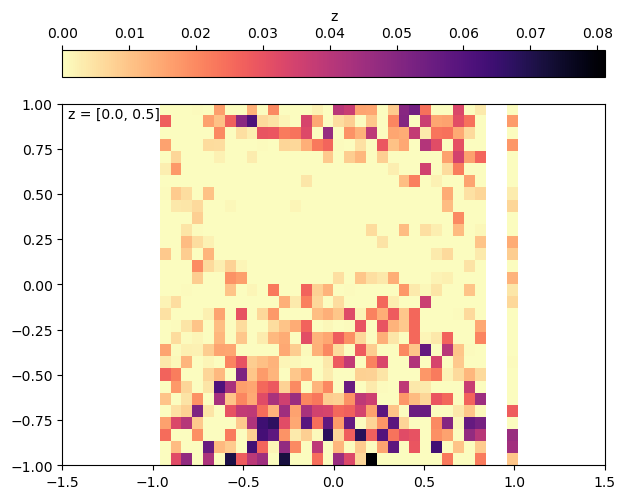

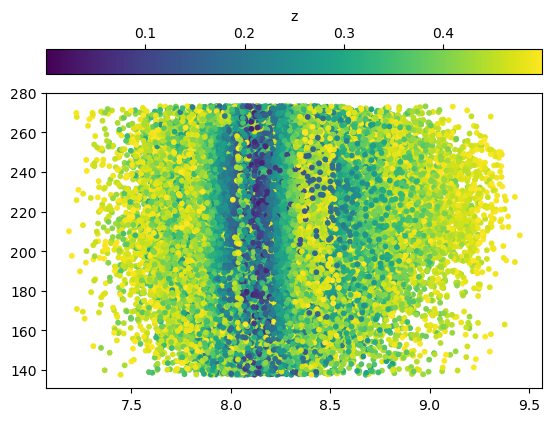

In [120]:
fig, ax = plt.subplots(1, figsize=(7,7))
r, phi, z, v_r, v_phi, v_z = phase_spiral_values(dist,
                                                 ra, dec,
                                                 pmra,
                                                 pmdec, 
                                                 vrad, dist_max = 12., dist_min=0.)
ind500 = np.where((z>0.)&(z<=0.5)&
                  #(abs(phi)>170)&(abs(phi)<190)&
                  (r>5.5)&(r<10.5)&
                  (abs(v_z)<100)&
                  (v_phi<np.nanpercentile(v_phi, 90.))&(v_phi>np.nanpercentile(v_phi, 1.)))

binning = [int((max(r[ind500])-min(r[ind500]))/0.01), int((max(-v_phi[ind500])-min(-v_phi[ind500])))]
print(binning)
binning = [50,30]



bin_r_vphi = scipy.stats.binned_statistic_2d(r[ind500], -v_phi[ind500], z[ind500], 'median', bins=(binning[0],binning[1]))

image = bin_r_vphi[0].T # transpose to make (r, v_phi)

#print(len(image[:,0]))

image_col_mean = np.copy(image)
for i in range(len(image[1])): # column length
    image_col_mean[:,i] = image[:,i] - np.median(image[:,i])

pcm = ax.imshow(image_col_mean,
                origin='lower',
                cmap = 'magma_r',
                norm = 'linear',
                #vmax = 60,
                vmin=-0,
                extent=[-1.5,1.5,-1,1]
               )
'''
x_label_list = np.array([np.round(min(r[ind500])),np.round(np.median(r[ind500])),np.round(max(r[ind500]))])
ax.set_xticks([-1.5,0.,1.5])
ax.set_xticklabels(x_label_list)
ax.set_xlabel('R [kpc]')


y_label_list = np.array([np.round(min(-v_phi[ind500])),np.round(np.median(-v_phi[ind500])),np.round(max(-v_phi[ind500]))])
ax.set_yticks([-1,0,1])
ax.set_yticklabels(y_label_list)
ax.set_ylabel('$v_\phi$ [km/s]')
'''
z_min_max = [np.round(min(z[ind500]), 2),np.round(max(z[ind500]), 2)]
ax.text(0.01, .99, 'z = %s' %z_min_max, ha='left', va='top', transform=ax.transAxes)
fig.colorbar(pcm, ax=ax, location='top', label='z')

plt.show()
pcm = plt.scatter(r[ind500], -v_phi[ind500],
            c=z[ind500],
           s=10)
fig.colorbar(pcm,location='top', label='z')

plt.show()

(0.0, 11.0)

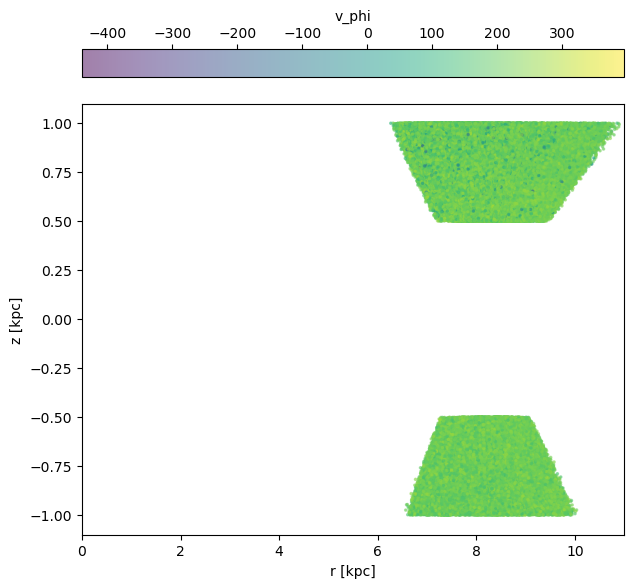

In [42]:
fig, ax = plt.subplots(1, figsize=(7,7))
r, phi, z, v_r, v_phi, v_z = phase_spiral_values(dist,
                                                 ra, dec,
                                                 pmra,
                                                 pmdec, 
                                                 vrad, dist_max = 12., dist_min=0.)
ind500 = np.where(
                  ((z>0.5)&(z<=1.0))|((z<-0.5)&(z>-1.0))&
                  #(abs(phi)>170)&(abs(phi)<190)&
                  (r>5.5)&(r<10.5)&
                  (abs(v_z)<100)&
                  (v_phi<np.nanpercentile(v_phi, 90.))&(v_phi>np.nanpercentile(v_phi, 1.)))

pcm = ax.scatter(r[ind500], z[ind500],
            c = -v_phi[ind500],
                s=10, 
                marker='.',
                alpha =0.5,
                cmap = 'viridis')
#ax.text(0.01, .99, 'R=8 kpc', ha='left', va='top', transform=ax.transAxes)
ax.set_xlabel('r [kpc]')
ax.set_ylabel('z [kpc]')
fig.colorbar(pcm, ax=ax, location='top', label='v_phi')
ax.set_xlim(0,11)


## test with hidt2d and log scale

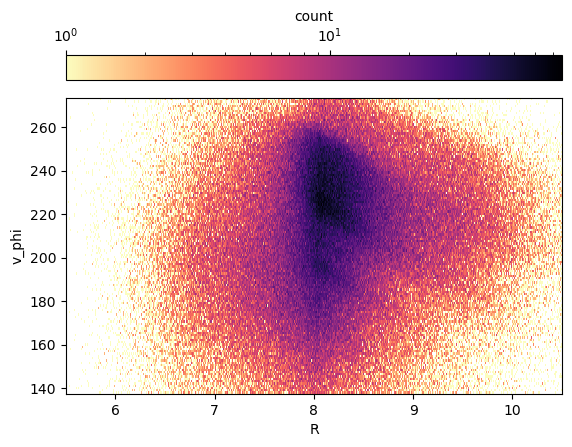

In [30]:
plt.hist2d(r[ind500],  -v_phi[ind500],norm='log', bins=[704, 129], cmap='magma_r')
plt.xlabel('R')
plt.ylabel('v_phi')
plt.colorbar(label='count',location='top')

In [31]:
(max(r[ind500]) - min(r[ind500]))/0.01


499.7140614423377

# khanna et al parameters

n (|φ − 180.0◦| < 25◦)&(|R − R|/kpc < 3.5). The colourbars represent logarithmic density.

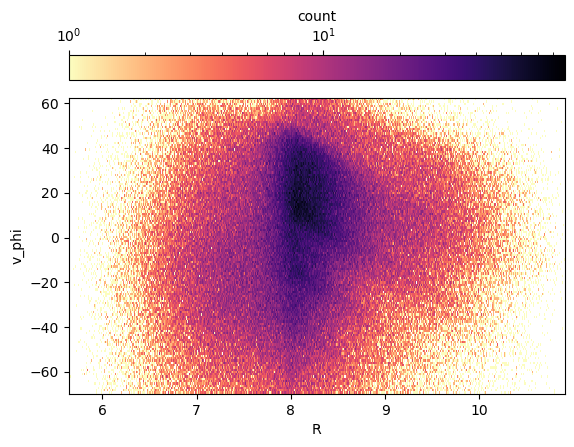

In [47]:
'''
n (|φ − 180.0◦| < 25◦)&(|R − R|/kpc < 3.5). The colourbars represent logarithmic density.
'''
r, phi, z, v_r, v_phi, v_z = phase_spiral_values(dist,
                                                 ra, dec,
                                                 pmra,
                                                 pmdec, 
                                                 vrad, dist_max = 3, dist_min=0)
ind500 = np.where(((abs(z))<=2.)&
                  (abs(phi)>155)&(abs(phi)<205) # |φ − 180.0◦| < 25◦
                  &(r>8-3.5)&(r<8+3.5)& # |R − R_sun|/kpc < 3.5
                  (abs(v_z)<100)&
                  (v_phi<np.nanpercentile(v_phi, 90))&(v_phi>np.nanpercentile(v_phi, 1)))

binning = [(max(r[ind500]) - min(r[ind500]))/0.01, (max(-v_phi[ind500]) - min(-v_phi[ind500]))/1]
bin_r_vphi = scipy.stats.binned_statistic_2d(r[ind500], -v_phi[ind500], None, 'count', bins=binning)

#fig, ax = plt.subplots(1,figsize=(5,5))


#par = plt.hist2d(x, y, norm=mpl.colors.LogNorm(), cmap=mpl.cm.gray)

plt.hist2d(r[ind500],  -v_phi[ind500]- (np.mean(-v_phi[ind500])) ,norm=mpl.colors.LogNorm(),  bins=[704, 129], cmap='magma_r')
plt.xlabel('R')
plt.ylabel('v_phi')
plt.colorbar(label='count',location='top')


#x_label_list = np.array([5.5,6.75,8.0,9.25,10.5])
#ax.set_xticks([-1.5,-0.75,0,0.75,1.5])
#ax.set_xticklabels(x_label_list)

#y_label_list = np.array([-230,-217.5,-205,-192.5,-180])
#ax.set_yticks([-1,-.5,0,0.5,1])
#ax.set_yticklabels(y_label_list)

ax.set_xlabel('r [kpc]')
ax.set_ylabel('$v_\phi$ [km/s]')
fig.colorbar(pcm, ax=ax, location='top', label='$v_\phi$  [km/s]')


## metallicities

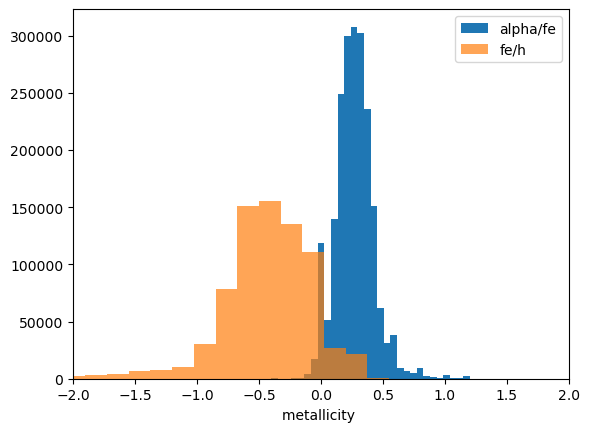

In [43]:
plt.hist(alphafe, bins=30, label='alpha/fe')
plt.hist(feh, bins=30, alpha=0.7, label='fe/h')
plt.xlabel('metallicity ')
plt.xlim(-2, 2)
plt.legend()
plt.show()


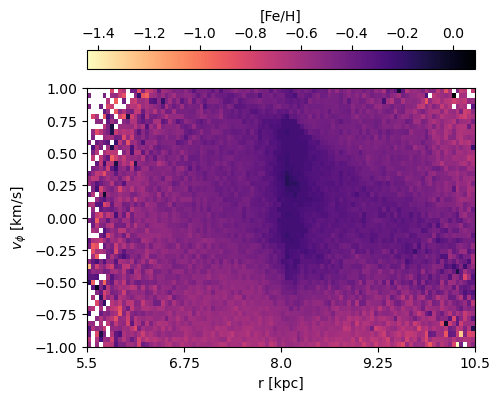

In [44]:
r, phi, z, v_r, v_phi, v_z = phase_spiral_values(dist,
                                                 ra, dec,
                                                 pmra,
                                                 pmdec, 
                                                 vrad, dist_max = 15, dist_min=0)
ind500 = np.where(((abs(z))<=2.)&
                  (abs(phi)>160)&(abs(phi)<200)
                  &(r>5.5)&(r<10.5)&
                  (abs(v_z)<100)&
                  (snr>20)&
                  (v_phi<np.nanpercentile(v_phi, 90))&(v_phi>np.nanpercentile(v_phi, 1)))


bin_r_vphi = scipy.stats.binned_statistic_2d(r[ind500], -v_phi[ind500], feh[ind500], 'median', bins=(100, 50))

fig, ax = plt.subplots(1,figsize=(5,5))
pcm = ax.imshow(bin_r_vphi.statistic.T,
                origin='lower',
                cmap = 'magma_r', 
                norm = 'linear',
                extent=[-1.5,1.5,-1,1])

x_label_list = np.array([5.5,6.75,8.0,9.25,10.5])
ax.set_xticks([-1.5,-0.75,0,0.75,1.5])
ax.set_xticklabels(x_label_list)

#y_label_list = np.array([-230,-217.5,-205,-192.5,-180])
#ax.set_yticks([-1,-.5,0,0.5,1])
#ax.set_yticklabels(y_label_list)

ax.set_xlabel('r [kpc]')
ax.set_ylabel('$v_\phi$ [km/s]')
fig.colorbar(pcm, ax=ax, location='top', label='[Fe/H]')

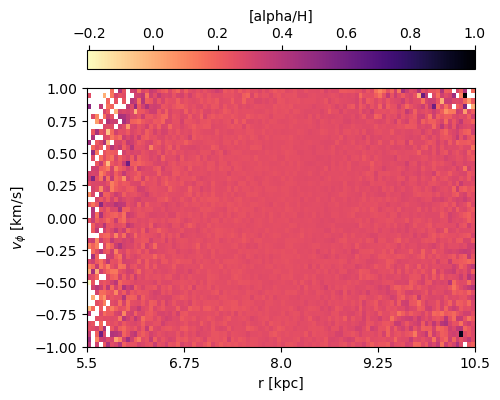

In [45]:
r, phi, z, v_r, v_phi, v_z = phase_spiral_values(dist,
                                                 ra, dec,
                                                 pmra,
                                                 pmdec, 
                                                 vrad, dist_max = 15, dist_min=0)
ind500 = np.where(((abs(z))<=2.)&
                  (abs(phi)>160)&(abs(phi)<200)
                  &(r>5.5)&(r<10.5)&
                  (abs(v_z)<100)&
                  (v_phi<np.nanpercentile(v_phi, 90))&(v_phi>np.nanpercentile(v_phi, 1)))


bin_r_vphi = scipy.stats.binned_statistic_2d(r[ind500], -v_phi[ind500], alphafe[ind500], 'median', bins=(100, 50))

fig, ax = plt.subplots(1,figsize=(5,5))
pcm = ax.imshow(bin_r_vphi.statistic.T,
                origin='lower',
                cmap = 'magma_r', 
                norm = 'linear',
                extent=[-1.5,1.5,-1,1])

x_label_list = np.array([5.5,6.75,8.0,9.25,10.5])
ax.set_xticks([-1.5,-0.75,0,0.75,1.5])
ax.set_xticklabels(x_label_list)

#y_label_list = np.array([-230,-217.5,-205,-192.5,-180])
#ax.set_yticks([-1,-.5,0,0.5,1])
#ax.set_yticklabels(y_label_list)

ax.set_xlabel('r [kpc]')
ax.set_ylabel('$v_\phi$ [km/s]')
fig.colorbar(pcm, ax=ax, location='top', label='[alpha/H]')

# both in one fig

-176.89614971284578 -247.59929372431807


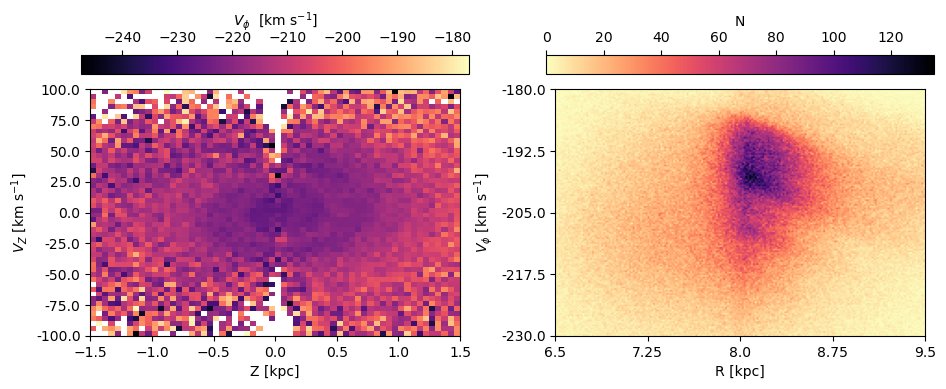

In [62]:

r, phi, z, v_r, v_phi, v_z = phase_spiral_values(dist,
                                                 ra, dec,
                                                 pmra,
                                                 pmdec, 
                                                 vrad, dist_max = 13, dist_min=0)
ind500 = np.where(((abs(z))<=1.5)&
                  (abs(phi)>160)&(abs(phi)<200)&
                  (r>7.5)&(r<8.5)& #8.24 kpc < R < 8.44
                  (abs(v_z)<100)&
                  (v_phi<np.nanpercentile(v_phi, 75))&(v_phi>np.nanpercentile(v_phi, 10)))
print(max(v_phi[ind500]), min(v_phi[ind500]))

bin_z_vz = scipy.stats.binned_statistic_2d(z[ind500], v_z[ind500], v_phi[ind500], 'median', bins=(60, 50))

fig, ax = plt.subplots(1,2,figsize=(11,4))

pcm = ax[0].imshow(bin_z_vz.statistic.T,
                origin='lower',norm = 'linear',
                cmap = 'magma', extent = [-1.5,1.5,-1,1])

y_label_list = np.array([-1,-.5,-0.75,-0.25,0,0.25,0.5,0.75,1])*100

ax[0].set_yticks([-1,-.5,-0.75,-0.25,0,0.25,0.5,0.75,1])

ax[0].set_yticklabels(y_label_list)

#ax.text(0.01, .99, 'R=8 kpc', ha='left', va='top', transform=ax.transAxes)
ax[0].set_xlabel('Z [kpc]')
ax[0].set_ylabel('$V_Z$ [km s$^{-1}$]')
fig.colorbar(pcm, ax=ax[0], location='top', label='$V_\phi$  [km s$^{-1}$]')


r, phi, z, v_r, v_phi, v_z = phase_spiral_values(dist,
                                                 ra, dec,
                                                 pmra,
                                                 pmdec, 
                                                 vrad, dist_max = 13, dist_min=0)
ind500 = np.where(((abs(z))<=7.)&
                  (abs(phi)>160)&(abs(phi)<200)&
                  (r>6.5)&(r<9.5)&
                  #(abs(v_z)<100)&
                  (v_phi<np.nanpercentile(v_phi, 90))&(v_phi>np.nanpercentile(v_phi, 1)))


bin_r_vphi = scipy.stats.binned_statistic_2d(r[ind500], -v_phi[ind500], None, 'count', bins=(200,150))


pcm = ax[1].imshow(bin_r_vphi.statistic.T,
                origin='lower',
                cmap = 'magma_r', extent=[-1.5,1.5,-1,1], norm='linear')


x_label_list = np.array([6.5,7.25,8.0,8.75,9.5])
ax[1].set_xticks([-1.5,-0.75,0,0.75,1.5])
ax[1].set_xticklabels(x_label_list)

y_label_list = np.array([-230,-217.5,-205,-192.5,-180])
ax[1].set_yticks([-1,-.5,0,0.5,1])
ax[1].set_yticklabels(y_label_list)

ax[1].set_xlabel('R [kpc]')
ax[1].set_ylabel('$V_\phi$ [km s$^{-1}$]')
fig.colorbar(pcm, ax=ax[1], location='top', label='N')

#fig.savefig('./z_vz_and_r_vphi_phase_diagrams.png', dpi=400)


# .......................................

# Phase Spiral

In [ ]:
# need distance, proper motion, and vrad

# sort into bright and dark program
dist_bright = dist[bright_index] # kpc
dist_dark = dist[dark_index]

pmra_bright = pmra[bright_index] # mas/yr
pmdec_bright = pmdec[bright_index]

pmra_dark = pmra[dark_index]
pmdec_dark = pmdec[dark_index]


vrad_bright = vrad[bright_index] # km/s # line of sight velocity
vrad_dark = vrad[dark_index]

ra_bright = ra[bright_index]
dec_bright = dec[bright_index]

ra_dark = ra[dark_index]
dec_dark = dec[dark_index]

snr_bright = snr[bright_index]
feh_bright=feh[bright_index]

print(len(feh_bright), len(ra_bright))



In [ ]:
# distance cut to within 0-2kpc
#dist_bright_cut2_index = np.where((dist_bright<=10) & (dist_bright>0))
dist_bright_cut2_index = np.where((dist_bright<=2) & (dist_bright>0))

dist_bright_cut2 = dist_bright[dist_bright_cut2_index]
ra_bright_cut2 = ra_bright[dist_bright_cut2_index]
dec_bright_cut2 = dec_bright[dist_bright_cut2_index]
pmra_bright_cut2 = pmra_bright[dist_bright_cut2_index]
pmdec_bright_cut2 = pmdec_bright[dist_bright_cut2_index]
vrad_bright_cut2 = vrad_bright[dist_bright_cut2_index]



In [ ]:
# test
r, phi, z, v_r, v_phi, v_z = phase_spiral_values(dist_bright, ra_bright, dec_bright, pmra_bright,
                                                 pmdec_bright, vrad_bright)


In [ ]:
plt.hist(v_r, bins=50)
plt.hist(v_phi, bins=50, alpha=0.7)
plt.hist(v_z, bins=50, alpha=0.7)
plt.yscale('log')

In [ ]:
plt.hist(r, bins=50, label='r')
plt.hist(phi, bins=50, alpha=0.7, label='phi')
plt.hist(z, bins=50, alpha=0.7, label='z')
plt.yscale('log')
plt.legend()

In [ ]:
fig, ax = plt.subplots(1,figsize=(5,5))

parallax_err_index = np.where((dist_bright>0)&(parallax_error_bright/parallax_bright <.2))

r, phi, z, v_r, v_phi, v_z = phase_spiral_values(dist_bright[parallax_err_index],
                                                 ra_bright[parallax_err_index], dec_bright[parallax_err_index],
                                                 pmra_bright[parallax_err_index],
                                                 pmdec_bright[parallax_err_index], 
                                                 vrad_bright[parallax_err_index], dist_max = 10, dist_min=0)
ind500 = np.where(((abs(z))<=1)&(abs(phi)>160)&(abs(phi)<200)&(r>7.5)&(r<8.44)&(abs(v_z)<150)&
                  (v_phi<np.nanpercentile(v_phi, 70))&(v_phi>np.nanpercentile(v_phi, 30)))
pcm = ax.scatter(z[ind500], v_z[ind500],
            c = v_phi[ind500],
                s=10, 
                marker='.',
                alpha =0.5,
                cmap = 'jet_r')
ax.text(0.01, .99, 'R=8 kpc', ha='left', va='top', transform=ax.transAxes)
ax.set_xlabel('z [kpc]')
ax.set_ylabel('v_z [km/s]')
#fig.colorbar(pcm, ax=ax, location='top', label='$v_\phi$  [km/s]')

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(11,4))

r, phi, z, v_r, v_phi, v_z = phase_spiral_values(dist_bright[parallax_err_index],
                                                 ra_bright[parallax_err_index], dec_bright[parallax_err_index],
                                                 pmra_bright[parallax_err_index],
                                                 pmdec_bright[parallax_err_index], vrad_bright[parallax_err_index],
                                                 dist_max = 10, dist_min=0)
ind500 = np.where(((abs(z))<=1)&(abs(phi)>160)&(abs(phi)<200)&(r>5.5)&(r<6.5)&(abs(v_z)<100)&
                  (v_phi<np.nanpercentile(v_phi, 70))&(v_phi>np.nanpercentile(v_phi, 30)))
pcm = ax[0].scatter(z[ind500], v_z[ind500],
            c = v_phi[ind500],
                s=10, 
                marker='.',
                alpha =0.5,
                cmap = 'jet_r')
ax[0].text(0.01, .99, 'R=6 kpc', ha='left', va='top', transform=ax[0].transAxes)
ax[0].set_xlabel('z [kpc]')
ax[0].set_ylabel('v_z [km/s]')
fig.colorbar(pcm, ax=ax[0], location='top', label='$v_\phi$  [km/s]')

####################################################################################


r, phi, z, v_r, v_phi, v_z = phase_spiral_values(dist_bright[parallax_err_index],
                                                 ra_bright[parallax_err_index], dec_bright[parallax_err_index],
                                                 pmra_bright[parallax_err_index],
                                                 pmdec_bright[parallax_err_index], vrad_bright[parallax_err_index],
                                                 dist_max =10, dist_min=0)
ind500 = np.where(((abs(z))<=1)&(abs(phi)>160)&(abs(phi)<200)&(r>7.5)&(r<8.5)&(abs(v_z)<100)&
                  (v_phi<np.nanpercentile(v_phi, 70))&(v_phi>np.nanpercentile(v_phi, 30)))
pcm = ax[1].scatter(z[ind500], v_z[ind500],
            c = v_phi[ind500],
                s=10, 
                marker='.',
                alpha =0.5,
                cmap = 'jet_r')
ax[1].text(0.01, .99, 'R=8 kpc', ha='left', va='top', transform=ax[1].transAxes)
fig.colorbar(pcm, ax=ax[1], location='top', label='$v_\phi$  [km/s]')


####################################################################################



r, phi, z, v_r, v_phi, v_z = phase_spiral_values(dist_bright[parallax_err_index],
                                                 ra_bright[parallax_err_index], dec_bright[parallax_err_index],
                                                 pmra_bright[parallax_err_index],
                                                 pmdec_bright[parallax_err_index], vrad_bright[parallax_err_index],
                                                 dist_max =10, dist_min=0)
ind500 = np.where(((abs(z))<=1)&(abs(phi)>160)&(abs(phi)<200)&(r>9.5)&(r<10.5)&(abs(v_z)<100)&
                  (v_phi<np.nanpercentile(v_phi, 70))&(v_phi>np.nanpercentile(v_phi, 30)))
pcm = ax[2].scatter(z[ind500], v_z[ind500],
            c = v_phi[ind500],
                s=10, 
                marker='.',
                alpha =0.5,
                cmap = 'jet_r')
ax[2].text(0.01, .99, 'R=10 kpc', ha='left', va='top', transform=ax[2].transAxes)
fig.colorbar(pcm, ax=ax[2], location='top', label=r'$v_\phi$ [km/s]')


In [ ]:
fig, ax = plt.subplots(1,3,figsize=(11,4))

r, phi, z, v_r, v_phi, v_z = phase_spiral_values(dist_bright, ra_bright, dec_bright, pmra_bright,
                                                 pmdec_bright, vrad_bright, dist_max = 2, dist_min=0)
ind500 = np.where(((abs(z))<=1)&(v_z<500)&(v_z>-500)&(v_phi<np.nanpercentile(v_phi, 70))&(v_phi>np.nanpercentile(v_phi, 30)))
pcm = ax[0].scatter(z[ind500], v_z[ind500],
            c = v_phi[ind500],
                s=10, 
                marker='.',
                alpha =0.5,
                cmap = 'jet_r')
ax[0].text(0.01, .99, 'D=0-2kpc', ha='left', va='top', transform=ax[0].transAxes)
ax[0].set_xlabel('z [kpc]')
ax[0].set_ylabel('v_z [km/s]')
fig.colorbar(pcm, ax=ax[0], location='top', label='$v_\phi$  [km/s]')

####################################################################################


r, phi, z, v_r, v_phi, v_z = phase_spiral_values(dist_bright, ra_bright, dec_bright, pmra_bright,
                                                 pmdec_bright, vrad_bright, dist_max =5, dist_min=2)
ind500 = np.where(((abs(z))<=1)&(v_z<500)&(v_z>-500)&
                  (v_phi<np.nanpercentile(v_phi, 70))&(v_phi>np.nanpercentile(v_phi, 30)))
pcm = ax[1].scatter(z[ind500], v_z[ind500],
            c = v_phi[ind500],
                s=10, 
                marker='.',
                alpha =0.5,
                cmap = 'jet_r')
ax[1].text(0.01, .99, 'D=2-5kpc', ha='left', va='top', transform=ax[1].transAxes)
fig.colorbar(pcm, ax=ax[1], location='top', label='$v_\phi$  [km/s]')


####################################################################################



r, phi, z, v_r, v_phi, v_z = phase_spiral_values(dist_bright, ra_bright, dec_bright, pmra_bright,
                                                 pmdec_bright, vrad_bright, dist_max =10, dist_min=5)
ind500 = np.where(((abs(z))<=1)&(v_z<500)&(v_z>-500)&(v_phi<np.nanpercentile(v_phi, 70))&(v_phi>np.nanpercentile(v_phi, 30)))
pcm = ax[2].scatter(z[ind500], v_z[ind500],
            c = v_phi[ind500],
                s=10, 
                marker='.',
                alpha =0.5,
                cmap = 'jet_r')
ax[2].text(0.01, .99, 'D=5-10 kpc', ha='left', va='top', transform=ax[2].transAxes)
fig.colorbar(pcm, ax=ax[2], location='top', label=r'$v_\phi$ [km/s]')


In [ ]:
#binning data???
'''
antoja et al: bins of ∆Z = 0.02 kpc and ∆VZ = 1km s−1
'''
ind500 = np.where(((abs(z))<=1)&(abs(phi)>160)&(abs(phi)<200)&(r>7.5)&(r<8.5)&(v_z<500)&(v_z>-500)&
                  (v_phi<np.nanpercentile(v_phi, 70))&(v_phi>np.nanpercentile(v_phi, 30)))


plt.hist2d(z[ind500], v_z[ind500], bins=100, norm=LogNorm(), cmap='magma')
plt.xlabel('z')
plt.ylabel('v_z')
plt.colorbar(label='count')

In [ ]:
plt.hexbin(z[ind500], v_z[ind500],
            C = v_phi[ind500])

In [ ]:
def binning(x,y,z, delta_x=0.02, delta_y=1):
    
    x_bins = np.arange(min(x)-delta_x, max(x)+delta_x, delta_x)
    y_bins = np.arange(min(y)-delta_x, max(y)+delta_x, delta_x)
    
    print(len(x))
    print(len(x_bins))

    #print(x_bins[0:2], x_bins[1:3], x_bins[2:4])
    #print(y_bins[0:2])
    
    x_bin_values = []
    y_bin_values = []
    z_bin_values = []
    
    for i in range(0,len(x_bins)-2):
        
        index_xy = np.where((x > x_bins[i])&(x < x_bins[i+2]))
        x_new = x[index_xy]
        y_new = y[index_xy]
        z_new = z[index_xy]
        #print(x_new)
        
        if len(x_new)>0:
            x_bin_values.append(np.median(x_new))
            y_bin_values.append(np.median(y_new))
            z_bin_values.append(np.median(z_new))
        else:
            x_bin_values.append(np.nan)
            y_bin_values.append(np.nan)
            z_bin_values.append(np.nan)
    
    
    print(len(x_bin_values))
    print(len(y_bin_values))
    print(len(z_bin_values))
    
    
    return x_bin_values, y_bin_values, z_bin_values
    
    
x_new, y_new, z_new = binning(z[ind500], v_z[ind500],v_phi[ind500])

In [ ]:
def binning2(x,y,z, num=800):
    

    x_bins = np.linspace(min(x), max(x), num)
    y_bins = np.linspace(min(y), max(y), num)
    z_bins = np.linspace(min(z), max(z), num)
    
    print(len(x))
    print(len(x_bins))
    print(len(y_bins))
    print(x_bins[1]-x_bins[0])
    print(y_bins[1]-y_bins[0])


    #print(x_bins[0:2], x_bins[1:3], x_bins[2:4])
    #print(y_bins[0:2])
    
    x_bin_values = []
    y_bin_values = []
    z_bin_values = []
    
    # is there a datapoint in x bin 1 and y bin 1?
    
    for i in range(0, len(x_bins)-1):
        print('i', i)
        
        indexx = np.where((x > x_bins[i])&(x < x_bins[i+1]))
        
        x_temp = x[indexx] # all the data points in the chosen x bin
        
        #print('xbin',x_bins[i],x_bins[i+1])

        if len(x_temp)>0:
            #x_bin_values.append(np.median(x_temp))
            #print(np.median(x_temp))
            
            for j in range(0,len(y_bins)-1):

                indexy = np.where((x > x_bins[i])&(x < x_bins[i+1])&(y > y_bins[j])&(y < y_bins[j+1]))
                y_temp = y[indexy]
                
                
                if len(y_temp)>0:
                    #x_bin_values.append(np.median(x_temp))
                    #y_bin_values.append(np.median(y_temp))
                    
                    for k in range(0,len(z_bins)-1):
                        indexz = np.where((x > x_bins[i])&(x < x_bins[i+1])&
                                          (y > y_bins[j])&(y < y_bins[j+1])&
                                          (z > z_bins[k])&(z < z_bins[k+1]))
                        z_temp = z[indexz]


                        if len(y_temp)>0:
                            x_bin_values.append(np.median(x_temp))
                            y_bin_values.append(np.median(y_temp))
                            z_bin_values.append(np.median(z_temp))
                            
                        #else:
                            #x_bin_values.append(np.nan)
                            #y_bin_values.append(np.nan)
                            #z_bin_values.append(np.nan)
                    
                    
                #else:
                    #x_bin_values.append(np.nan)
                    #y_bin_values.append(np.nan)
                    #z_bin_values.append(np.nan)
        #else:
            #x_bin_values.append(np.nan)
            #y_bin_values.append(np.nan)
            #z_bin_values.append(np.nan)

    
    
    return x_bin_values, y_bin_values, z_bin_values
    
    
x_new, y_new, z_new = binning2(z[ind500], v_z[ind500],v_phi[ind500])

In [ ]:
#x_new = np.array(x_new)
#y_new = np.array(y_new)
#z_new = np.array(z_new)

print(len(z_new))

df = pd.DataFrame({"z" : x_new, "v_z" : y_new, 'v_phi': z_new})
df.to_csv("./binned_phase_spiral_8kpc.csv")

In [ ]:
print(len(np.where(~np.isnan(x_new))[0]))

In [ ]:
fig, ax = plt.subplots(1,figsize=(7,7))
pcm = ax.scatter(x_new, y_new,
            c = z_new,
                s=10, 
                marker='.',
                alpha =0.5,
                cmap = 'jet_r')
ax.text(0.01, .99, 'R=8 kpc', ha='left', va='top', transform=ax.transAxes)
fig.colorbar(pcm, ax=ax, location='top', label='$v_\phi$  [km/s]')

fig.savefig('./bin_attempt.png')

